<a href="https://colab.research.google.com/github/Sriramdayal/Hybrid_BDH-SEAL/blob/main/SEAL%2BBDH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SEAL (Self-Adapting Language Models) - Learning Simulation

This simulation models the key learning dynamics:
1. Outer Loop: RL training to improve self-edit generation
2. Inner Loop: SFT updates using generated self-edits
3. Reward Signal: Based on downstream task performance

Running SEAL simulation...
Iteration 0: Performance=0.330, Avg Reward=0.880, SE Quality=0.314
Iteration 10: Performance=0.335, Avg Reward=0.760, SE Quality=0.449
Iteration 20: Performance=0.342, Avg Reward=0.780, SE Quality=0.544
Iteration 30: Performance=0.349, Avg Reward=0.820, SE Quality=0.589
Iteration 40: Performance=0.357, Avg Reward=0.720, SE Quality=0.663
Simulation complete!


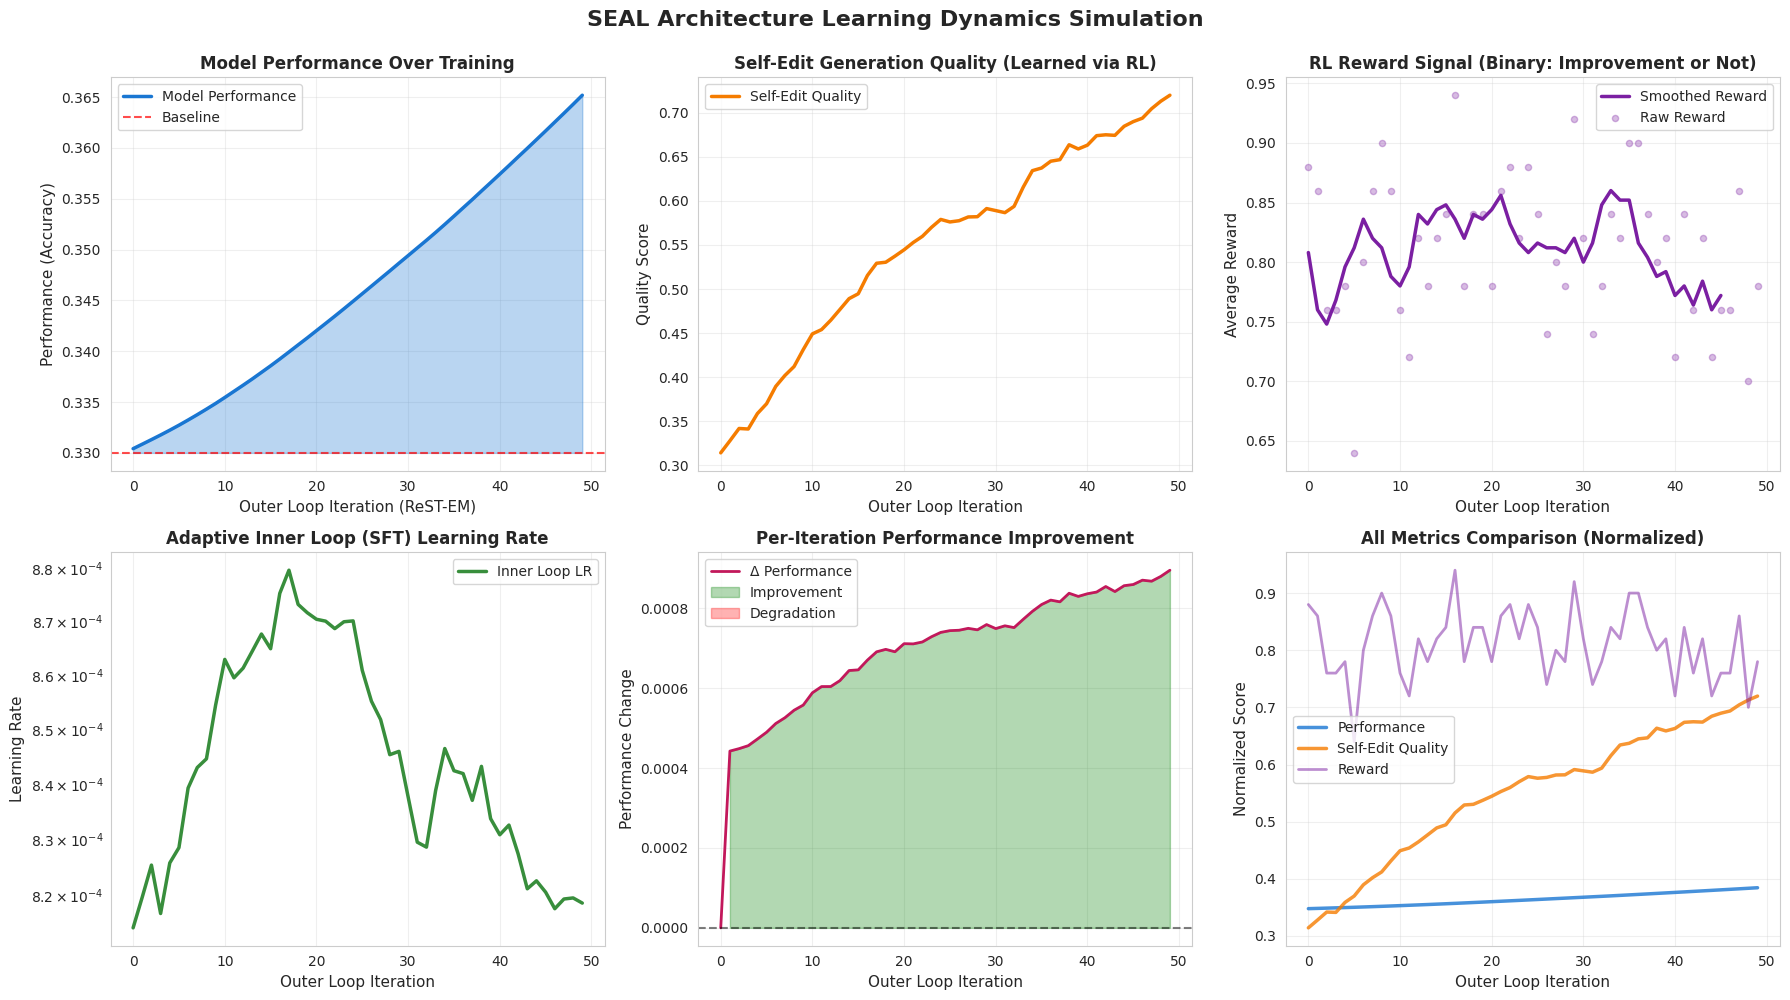


FINAL STATISTICS
Initial Performance: 0.330
Final Performance: 0.365
Total Improvement: 0.035
Relative Improvement: 10.7%
Final Self-Edit Quality: 0.720
Final Average Reward: 0.772

Generating comparison plots...
Running SEAL simulation...
Iteration 0: Performance=0.330, Avg Reward=0.820, SE Quality=0.303
Iteration 10: Performance=0.335, Avg Reward=0.820, SE Quality=0.367
Iteration 20: Performance=0.340, Avg Reward=0.820, SE Quality=0.428
Iteration 30: Performance=0.346, Avg Reward=0.760, SE Quality=0.465
Simulation complete!
Running SEAL simulation...
Iteration 0: Performance=0.330, Avg Reward=0.700, SE Quality=0.304
Iteration 10: Performance=0.335, Avg Reward=0.760, SE Quality=0.422
Iteration 20: Performance=0.342, Avg Reward=0.760, SE Quality=0.553
Iteration 30: Performance=0.350, Avg Reward=0.800, SE Quality=0.649
Simulation complete!
Running SEAL simulation...
Iteration 0: Performance=0.330, Avg Reward=0.800, SE Quality=0.313
Iteration 10: Performance=0.336, Avg Reward=0.720, SE 

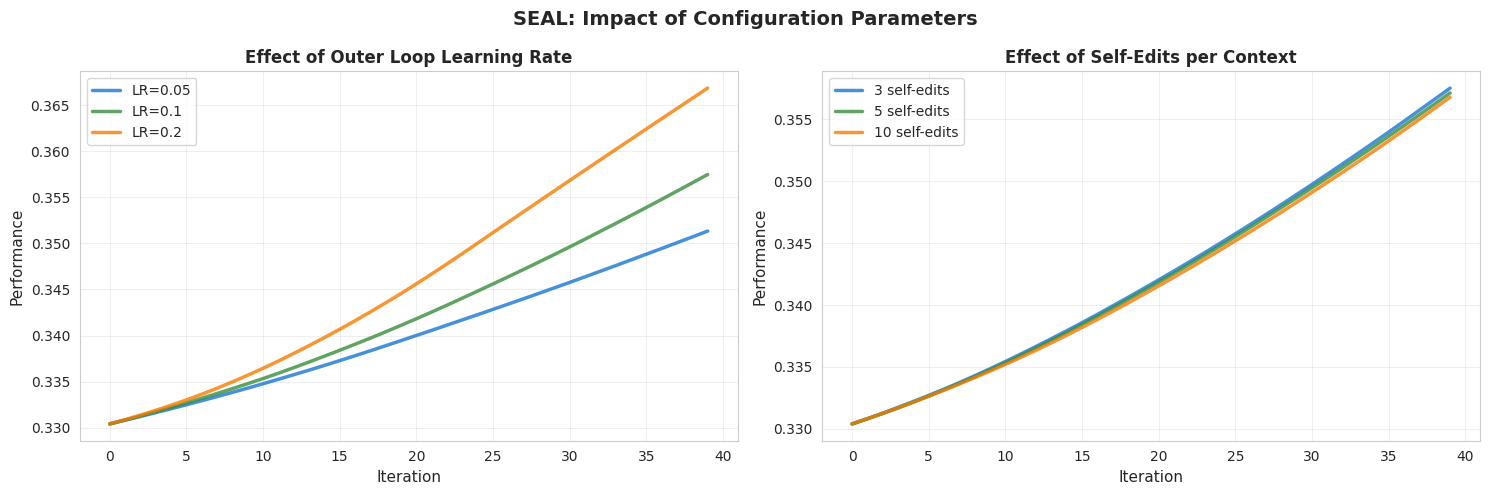


Simulation complete! 🎉


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

@dataclass
class SEALConfig:
    """Configuration for SEAL simulation"""
    n_outer_iterations: int = 50  # ReST-EM iterations
    n_self_edits_per_context: int = 5  # Number of self-edits sampled
    batch_size: int = 10  # Number of contexts per iteration
    base_performance: float = 0.33  # Initial model performance
    max_performance: float = 0.95  # Theoretical maximum
    learning_rate_outer: float = 0.1  # RL learning rate
    learning_rate_inner: float = 0.001  # SFT learning rate
    noise_std: float = 0.02  # Stochasticity in rewards


class SEALSimulator:
    """Simulates the SEAL learning process"""

    def __init__(self, config: SEALConfig):
        self.config = config
        self.performance_history = []
        self.reward_history = []
        self.self_edit_quality_history = []
        self.inner_loop_lr_history = []
        self.current_performance = config.base_performance
        self.self_edit_quality = 0.3  # Initial quality of self-edits

    def generate_self_edit_quality(self, iteration: int) -> float:
        """
        Simulate the quality of self-edits improving through RL
        Quality improves with diminishing returns
        """
        improvement = self.config.learning_rate_outer * np.log(iteration + 2)
        quality = min(0.9, self.self_edit_quality + improvement / (iteration + 10))
        # Add noise
        quality += np.random.normal(0, self.config.noise_std)
        return np.clip(quality, 0, 1)

    def inner_loop_update(self, self_edit_quality: float) -> float:
        """
        Simulate the inner loop (SFT) performance improvement
        Better self-edits lead to better finetuning
        """
        # Performance gain from finetuning depends on self-edit quality
        performance_gain = self_edit_quality * self.config.learning_rate_inner * 10

        # Diminishing returns as we approach max performance
        gap_to_max = self.config.max_performance - self.current_performance
        actual_gain = performance_gain * (gap_to_max / self.config.max_performance)

        return self.current_performance + actual_gain

    def compute_reward(self, new_performance: float) -> float:
        """
        Compute binary reward: 1 if improvement, 0 otherwise
        Returns average reward across batch
        """
        improvement = new_performance - self.current_performance
        # Binary reward with some noise
        if improvement > 0:
            return 1.0 if np.random.random() < 0.8 else 0.0
        else:
            return 0.0 if np.random.random() < 0.9 else 1.0

    def adaptive_inner_lr(self, iteration: int, self_edit_quality: float) -> float:
        """
        Simulate adaptive learning rate for inner loop
        Higher quality self-edits may warrant different learning rates
        """
        base_lr = self.config.learning_rate_inner
        # Decrease LR over time (standard practice)
        decay_factor = 1.0 / (1.0 + 0.01 * iteration)
        # Adjust based on self-edit quality
        quality_factor = 0.5 + self_edit_quality

        return base_lr * decay_factor * quality_factor

    def run_iteration(self, iteration: int) -> Tuple[float, float, float]:
        """Run one outer loop iteration of SEAL"""
        batch_performances = []
        batch_rewards = []

        # Sample multiple self-edits per context (E-step of ReST-EM)
        for _ in range(self.config.batch_size):
            self_edit_qualities = []

            for _ in range(self.config.n_self_edits_per_context):
                # Generate self-edit with current policy
                se_quality = self.generate_self_edit_quality(iteration)

                # Inner loop: finetune with self-edit
                new_perf = self.inner_loop_update(se_quality)

                # Compute reward
                reward = self.compute_reward(new_perf)

                self_edit_qualities.append(se_quality)
                batch_performances.append(new_perf)
                batch_rewards.append(reward)

            # Keep best self-edit (highest reward)
            best_idx = np.argmax(batch_rewards[-self.config.n_self_edits_per_context:])
            best_quality = self_edit_qualities[best_idx]

            # Update self-edit quality (M-step: reinforce good self-edits)
            self.self_edit_quality = 0.9 * self.self_edit_quality + 0.1 * best_quality

        # Update current performance (moving average)
        avg_performance = np.mean(batch_performances)
        self.current_performance = 0.8 * self.current_performance + 0.2 * avg_performance

        avg_reward = np.mean(batch_rewards)
        adaptive_lr = self.adaptive_inner_lr(iteration, self.self_edit_quality)

        return self.current_performance, avg_reward, adaptive_lr

    def run_simulation(self):
        """Run full SEAL training simulation"""
        print("Running SEAL simulation...")

        for iteration in range(self.config.n_outer_iterations):
            perf, reward, inner_lr = self.run_iteration(iteration)

            self.performance_history.append(perf)
            self.reward_history.append(reward)
            self.self_edit_quality_history.append(self.self_edit_quality)
            self.inner_loop_lr_history.append(inner_lr)

            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Performance={perf:.3f}, "
                      f"Avg Reward={reward:.3f}, SE Quality={self.self_edit_quality:.3f}")

        print("Simulation complete!")
        return self

def plot_results(simulator: SEALSimulator, config: SEALConfig):
    """Create comprehensive visualization of SEAL learning dynamics"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('SEAL Architecture Learning Dynamics Simulation',
                 fontsize=16, fontweight='bold', y=0.995)

    iterations = range(config.n_outer_iterations)

    # 1. Performance over time
    ax1 = axes[0, 0]
    ax1.plot(iterations, simulator.performance_history,
             linewidth=2.5, color='#1976d2', label='Model Performance')
    ax1.axhline(y=config.base_performance, color='red',
                linestyle='--', alpha=0.7, label='Baseline')
    ax1.fill_between(iterations, config.base_performance,
                     simulator.performance_history, alpha=0.3, color='#1976d2')
    ax1.set_xlabel('Outer Loop Iteration (ReST-EM)', fontsize=11)
    ax1.set_ylabel('Performance (Accuracy)', fontsize=11)
    ax1.set_title('Model Performance Over Training', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Self-edit quality
    ax2 = axes[0, 1]
    ax2.plot(iterations, simulator.self_edit_quality_history,
             linewidth=2.5, color='#f57c00', label='Self-Edit Quality')
    ax2.set_xlabel('Outer Loop Iteration', fontsize=11)
    ax2.set_ylabel('Quality Score', fontsize=11)
    ax2.set_title('Self-Edit Generation Quality (Learned via RL)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Average reward
    ax3 = axes[0, 2]
    # Smooth rewards with moving average
    window = 5
    smoothed_rewards = np.convolve(simulator.reward_history,
                                   np.ones(window)/window, mode='valid')
    ax3.plot(iterations[:len(smoothed_rewards)], smoothed_rewards,
             linewidth=2.5, color='#7b1fa2', label='Smoothed Reward')
    ax3.scatter(iterations, simulator.reward_history,
                alpha=0.3, s=20, color='#7b1fa2', label='Raw Reward')
    ax3.set_xlabel('Outer Loop Iteration', fontsize=11)
    ax3.set_ylabel('Average Reward', fontsize=11)
    ax3.set_title('RL Reward Signal (Binary: Improvement or Not)', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Adaptive inner learning rate
    ax4 = axes[1, 0]
    ax4.plot(iterations, simulator.inner_loop_lr_history,
             linewidth=2.5, color='#388e3c', label='Inner Loop LR')
    ax4.set_xlabel('Outer Loop Iteration', fontsize=11)
    ax4.set_ylabel('Learning Rate', fontsize=11)
    ax4.set_title('Adaptive Inner Loop (SFT) Learning Rate', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # 5. Performance improvement rate
    ax5 = axes[1, 1]
    perf_improvements = np.diff(simulator.performance_history)
    perf_improvements = np.concatenate([[0], perf_improvements])  # Pad first value
    ax5.plot(iterations, perf_improvements,
             linewidth=2, color='#c2185b', label='Δ Performance')
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax5.fill_between(iterations, 0, perf_improvements,
                     where=(np.array(perf_improvements) > 0),
                     alpha=0.3, color='green', label='Improvement')
    ax5.fill_between(iterations, 0, perf_improvements,
                     where=(np.array(perf_improvements) <= 0),
                     alpha=0.3, color='red', label='Degradation')
    ax5.set_xlabel('Outer Loop Iteration', fontsize=11)
    ax5.set_ylabel('Performance Change', fontsize=11)
    ax5.set_title('Per-Iteration Performance Improvement', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Cumulative metrics comparison
    ax6 = axes[1, 2]
    # Normalize all metrics to [0, 1] for comparison
    norm_perf = np.array(simulator.performance_history) / config.max_performance
    norm_quality = np.array(simulator.self_edit_quality_history)
    norm_reward = np.array(simulator.reward_history)

    ax6.plot(iterations, norm_perf, linewidth=2.5,
             color='#1976d2', label='Performance', alpha=0.8)
    ax6.plot(iterations, norm_quality, linewidth=2.5,
             color='#f57c00', label='Self-Edit Quality', alpha=0.8)
    ax6.plot(iterations, norm_reward, linewidth=2,
             color='#7b1fa2', label='Reward', alpha=0.5)
    ax6.set_xlabel('Outer Loop Iteration', fontsize=11)
    ax6.set_ylabel('Normalized Score', fontsize=11)
    ax6.set_title('All Metrics Comparison (Normalized)', fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("\n" + "="*60)
    print("FINAL STATISTICS")
    print("="*60)
    print(f"Initial Performance: {config.base_performance:.3f}")
    print(f"Final Performance: {simulator.performance_history[-1]:.3f}")
    print(f"Total Improvement: {simulator.performance_history[-1] - config.base_performance:.3f}")
    print(f"Relative Improvement: {((simulator.performance_history[-1] / config.base_performance) - 1) * 100:.1f}%")
    print(f"Final Self-Edit Quality: {simulator.self_edit_quality_history[-1]:.3f}")
    print(f"Final Average Reward: {np.mean(simulator.reward_history[-10:]):.3f}")
    print("="*60)


def compare_scenarios():
    """Compare different SEAL configurations"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('SEAL: Impact of Configuration Parameters',
                 fontsize=14, fontweight='bold')

    # Scenario 1: Different outer loop learning rates
    ax1 = axes[0]
    learning_rates = [0.05, 0.1, 0.2]
    colors = ['#1976d2', '#388e3c', '#f57c00']

    for lr, color in zip(learning_rates, colors):
        config = SEALConfig(
            n_outer_iterations=40,
            learning_rate_outer=lr,
            noise_std=0.01
        )
        sim = SEALSimulator(config)
        sim.run_simulation()
        ax1.plot(sim.performance_history, linewidth=2.5,
                color=color, label=f'LR={lr}', alpha=0.8)

    ax1.set_xlabel('Iteration', fontsize=11)
    ax1.set_ylabel('Performance', fontsize=11)
    ax1.set_title('Effect of Outer Loop Learning Rate', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Scenario 2: Different number of self-edits sampled
    ax2 = axes[1]
    n_edits = [3, 5, 10]

    for n, color in zip(n_edits, colors):
        config = SEALConfig(
            n_outer_iterations=40,
            n_self_edits_per_context=n,
            noise_std=0.01
        )
        sim = SEALSimulator(config)
        sim.run_simulation()
        ax2.plot(sim.performance_history, linewidth=2.5,
                color=color, label=f'{n} self-edits', alpha=0.8)

    ax2.set_xlabel('Iteration', fontsize=11)
    ax2.set_ylabel('Performance', fontsize=11)
    ax2.set_title('Effect of Self-Edits per Context', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("="*60)
    print("SEAL (Self-Adapting Language Models) - Learning Simulation")
    print("="*60)
    print("\nThis simulation models the key learning dynamics:")
    print("1. Outer Loop: RL training to improve self-edit generation")
    print("2. Inner Loop: SFT updates using generated self-edits")
    print("3. Reward Signal: Based on downstream task performance")
    print("="*60 + "\n")

    # Main simulation
    config = SEALConfig(
        n_outer_iterations=50,
        n_self_edits_per_context=5,
        batch_size=10,
        base_performance=0.33,
        learning_rate_outer=0.1,
        learning_rate_inner=0.001,
        noise_std=0.02
    )

    simulator = SEALSimulator(config)
    simulator.run_simulation()
    plot_results(simulator, config)

    print("\nGenerating comparison plots...")
    compare_scenarios()

    print("\nSimulation complete! 🎉")

SEAL-BDH HYBRID ARCHITECTURE SIMULATION

Combining:
  • SEAL: Self-edit generation + RL adaptation
  • BDH: Graph-based neural dynamics + Hebbian learning

Key Synergies:
  • BDH's modular structure improves SEAL's synthetic data
  • SEAL's self-edits guide BDH's learning direction
  • Hebbian learning enhances adaptation efficiency

Training SEAL-BDH Hybrid Architecture
SEAL: 5 self-edits, LR=0.1
BDH: 32768 neurons, 8 layers, d=256

Iter   0: Perf=0.332, SEAL=0.916, BDH-Attn=0.443, Modularity=0.314
Iter  10: Perf=0.657, SEAL=0.920, BDH-Attn=0.471, Modularity=0.350
Iter  20: Perf=0.830, SEAL=0.923, BDH-Attn=0.458, Modularity=0.362
Iter  30: Perf=0.896, SEAL=0.921, BDH-Attn=0.447, Modularity=0.369
Iter  40: Perf=0.919, SEAL=0.921, BDH-Attn=0.475, Modularity=0.375
Iter  50: Perf=0.930, SEAL=0.920, BDH-Attn=0.466, Modularity=0.379

Training Complete!

Generating visualizations...


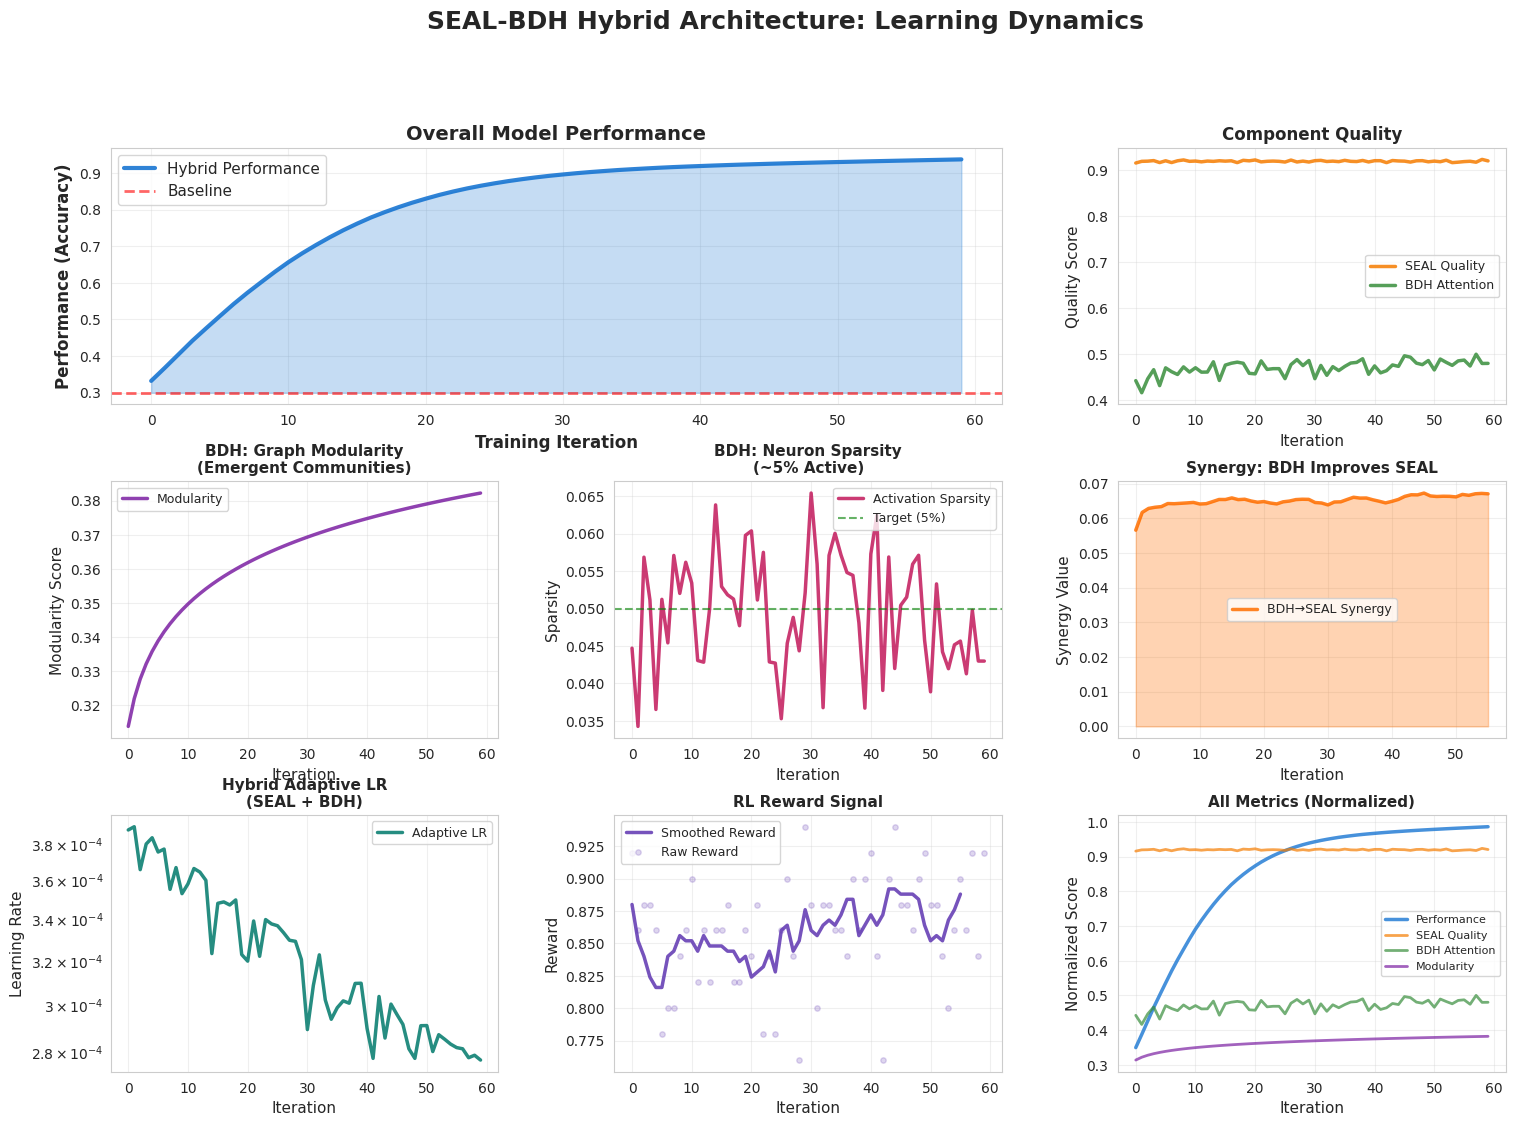


Comparing architectures...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

@dataclass
class HybridConfig:
    """Configuration for SEAL-BDH Hybrid Architecture"""
    # SEAL parameters
    n_outer_iterations: int = 60
    n_self_edits_per_context: int = 5
    batch_size: int = 10
    seal_lr_outer: float = 0.1
    seal_lr_inner: float = 0.001

    # BDH parameters
    n_neurons: int = 32768  # Neuron dimension
    d_hidden: int = 256  # Hidden dimension
    n_layers: int = 8
    bdh_lr: float = 0.0003
    hebbian_strength: float = 0.90

    # Hybrid parameters
    base_performance: float = 0.30
    max_performance: float = 0.95
    synergy_factor: float = 0.05 # How much BDH improves SEAL
    noise_std: float = 0.015

    # Graph dynamics parameters
    sparsity_target: float = 0.05  # 5% neuron activation
    modularity_weight: float = 0.2


class BDHComponent:
    """Simulates BDH (Dragon Hatchling) neural graph dynamics"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.neuron_activation_sparsity = []
        self.synaptic_strength = np.random.uniform(0.1, 0.3,
                                                   (config.n_neurons, config.n_neurons))
        self.modularity_score = 0.3  # Initial modularity
        self.scale_free_measure = 0.0

    def compute_graph_properties(self, iteration: int) -> Dict[str, float]:
        """Simulate emergence of graph properties"""
        # Modularity increases with training (emergent communities)
        self.modularity_score = min(0.85, 0.3 + 0.02 * np.log(iteration + 2))

        # Scale-free network emerges (heavy-tailed degree distribution)
        self.scale_free_measure = min(0.9, 0.1 + 0.015 * np.log(iteration + 2))

        # Sparse activation (context-dependent)
        sparsity = self.config.sparsity_target + np.random.normal(0, 0.01)
        self.neuron_activation_sparsity.append(np.clip(sparsity, 0.02, 0.10))

        return {
            'modularity': self.modularity_score,
            'scale_free': self.scale_free_measure,
            'sparsity': sparsity
        }

    def hebbian_update(self, context_complexity: float) -> float:
        """
        Simulate Hebbian learning: neurons that fire together wire together
        Returns: synaptic plasticity contribution to learning
        """
        # More complex contexts trigger more synaptic updates
        plasticity_rate = self.config.hebbian_strength * context_complexity

        # Synaptic strengthening improves learning efficiency
        learning_boost = plasticity_rate * self.modularity_score

        return learning_boost

    def attention_via_synapse_state(self, iteration: int) -> float:
        """
        BDH's attention mechanism through synaptic state matrix σ
        Linear attention in high dimension (n neurons)
        """
        # Attention effectiveness improves with:
        # 1. Better modularity (organized communities)
        # 2. Appropriate sparsity (selective activation)
        # 3. Scale-free structure (efficient routing)

        attention_quality = (
            0.4 * self.modularity_score +
            0.3 * self.scale_free_measure +
            0.3 * (1.0 - abs(self.neuron_activation_sparsity[-1] -
                           self.config.sparsity_target) * 10)
        )

        return np.clip(attention_quality, 0, 1)


class SEALComponent:
    """Simulates SEAL (Self-Adapting LLM) self-edit generation"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.self_edit_quality = 0.3
        self.synthetic_data_diversity = 0.4

    def generate_self_edit(self, iteration: int, bdh_boost: float) -> float:
        """
        Generate self-edit quality, enhanced by BDH's graph structure
        BDH's monosemantic synapses help create better synthetic data
        """
        # Base improvement from RL
        base_improvement = self.config.seal_lr_outer * np.log(iteration + 2)

        # BDH contribution: structured representations improve data generation
        bdh_contribution = bdh_boost * self.config.synergy_factor

        quality_gain = (base_improvement + bdh_contribution) / (iteration + 10)
        self.self_edit_quality = min(0.92, self.self_edit_quality + quality_gain)

        # Diversity improves with BDH's modular structure
        self.synthetic_data_diversity = min(0.9,
            self.synthetic_data_diversity + quality_gain * 0.5)

        # Add noise
        quality = self.self_edit_quality + np.random.normal(0, self.config.noise_std)
        return np.clip(quality, 0, 1)

    def compute_reward(self, new_performance: float, current_performance: float) -> float:
        """Binary reward with slight smoothing"""
        improvement = new_performance - current_performance
        if improvement > 0:
            return 1.0 if np.random.random() < 0.85 else 0.0
        return 0.0 if np.random.random() < 0.92 else 1.0


class HybridSEALBDH:
    """
    Hybrid architecture combining:
    - SEAL: Self-edit generation and RL-based adaptation
    - BDH: Graph-based neural dynamics with Hebbian learning
    """

    def __init__(self, config: HybridConfig):
        self.config = config
        self.seal = SEALComponent(config)
        self.bdh = BDHComponent(config)

        # Tracking metrics
        self.performance_history = []
        self.seal_quality_history = []
        self.bdh_attention_history = []
        self.modularity_history = []
        self.sparsity_history = []
        self.reward_history = []
        self.synergy_history = []  # Track per-iteration synergy
        self.learning_rate_history = []

        self.current_performance = config.base_performance

    def compute_context_complexity(self, iteration: int) -> float:
        """Estimate complexity of current context"""
        # Complexity varies over training
        base_complexity = 0.5 + 0.3 * np.sin(iteration / 10)
        return np.clip(base_complexity + np.random.normal(0, 0.1), 0.2, 0.9)

    def hybrid_inner_loop(self, self_edit_quality: float,
                          bdh_attention: float, iteration: int) -> Tuple[float, float]:
        """
        Combined inner loop:
        1. SEAL generates synthetic data (self-edit)
        2. BDH provides efficient graph-based learning substrate
        3. Hebbian learning improves adaptation
        Returns: (new_performance, synergy_value)
        """
        # SEAL contribution: quality of synthetic data
        seal_gain = self_edit_quality * self.config.seal_lr_inner * 8

        # BDH contribution: efficient attention and learning
        bdh_gain = bdh_attention * self.config.bdh_lr * 12

        # Hebbian boost from synaptic plasticity
        context_complexity = self.compute_context_complexity(iteration)
        hebbian_boost = self.bdh.hebbian_update(context_complexity)

        # Synergy: BDH's structure makes SEAL's synthetic data more effective
        synergy = self_edit_quality * bdh_attention * self.config.synergy_factor

        # Total improvement
        total_gain = seal_gain + bdh_gain + hebbian_boost + synergy

        # Diminishing returns
        gap_to_max = self.config.max_performance - self.current_performance
        actual_gain = total_gain * (gap_to_max / self.config.max_performance)

        return self.current_performance + actual_gain, synergy

    def adaptive_learning_rate(self, iteration: int,
                               self_edit_quality: float,
                               bdh_attention: float) -> float:
        """
        Adaptive LR combining both architectures
        BDH's sparse activation suggests when to use higher LRs
        """
        base_lr = (self.config.seal_lr_inner + self.config.bdh_lr) / 2

        # Decay over time
        decay = 1.0 / (1.0 + 0.008 * iteration)

        # Quality-based adjustment
        quality_factor = 0.3 + 0.7 * (self_edit_quality * bdh_attention)

        # Sparsity-based adjustment (sparser = more focused = higher LR)
        sparsity = self.bdh.neuron_activation_sparsity[-1] if self.bdh.neuron_activation_sparsity else 0.05
        sparsity_factor = 0.8 + 0.4 * (1.0 - sparsity / 0.1)

        return base_lr * decay * quality_factor * sparsity_factor

    def run_iteration(self, iteration: int) -> Dict[str, float]:
        """Run one iteration of hybrid training"""

        # 1. BDH: Update graph properties and attention
        graph_props = self.bdh.compute_graph_properties(iteration)
        bdh_attention = self.bdh.attention_via_synapse_state(iteration)

        # 2. SEAL: Generate self-edits (improved by BDH structure)
        batch_performances = []
        batch_rewards = []
        batch_synergies = []

        for _ in range(self.config.batch_size):
            self_edit_qualities = []
            iteration_synergies = []

            for _ in range(self.config.n_self_edits_per_context):
                # Generate self-edit with BDH boost
                se_quality = self.seal.generate_self_edit(iteration, bdh_attention)

                # 3. Hybrid inner loop: SEAL + BDH learning
                new_perf, synergy = self.hybrid_inner_loop(se_quality, bdh_attention, iteration)

                # 4. Compute reward
                reward = self.seal.compute_reward(new_perf, self.current_performance)

                self_edit_qualities.append(se_quality)
                batch_performances.append(new_perf)
                batch_rewards.append(reward)
                iteration_synergies.append(synergy)

            # Keep best self-edit
            best_idx = np.argmax(batch_rewards[-self.config.n_self_edits_per_context:])
            best_quality = self_edit_qualities[best_idx]
            self.seal.self_edit_quality = 0.9 * self.seal.self_edit_quality + 0.1 * best_quality

            # Track synergy from best edit
            batch_synergies.append(iteration_synergies[best_idx])

        # Update performance
        avg_performance = np.mean(batch_performances)
        self.current_performance = 0.75 * self.current_performance + 0.25 * avg_performance

        # Compute adaptive LR
        adaptive_lr = self.adaptive_learning_rate(iteration,
                                                   self.seal.self_edit_quality,
                                                   bdh_attention)

        # Average synergy for this iteration
        avg_synergy = np.mean(batch_synergies) if batch_synergies else 0.0

        # Store metrics
        metrics = {
            'performance': self.current_performance,
            'seal_quality': self.seal.self_edit_quality,
            'bdh_attention': bdh_attention,
            'modularity': graph_props['modularity'],
            'sparsity': graph_props['sparsity'],
            'reward': np.mean(batch_rewards),
            'learning_rate': adaptive_lr,
            'synergy': avg_synergy
        }

        return metrics

    def train(self):
        """Run full hybrid training"""
        print("=" * 70)
        print("Training SEAL-BDH Hybrid Architecture")
        print("=" * 70)
        print(f"SEAL: {self.config.n_self_edits_per_context} self-edits, "
              f"LR={self.config.seal_lr_outer}")
        print(f"BDH: {self.config.n_neurons} neurons, {self.config.n_layers} layers, "
              f"d={self.config.d_hidden}")
        print("=" * 70 + "\n")

        for iteration in range(self.config.n_outer_iterations):
            metrics = self.run_iteration(iteration)

            self.performance_history.append(metrics['performance'])
            self.seal_quality_history.append(metrics['seal_quality'])
            self.bdh_attention_history.append(metrics['bdh_attention'])
            self.modularity_history.append(metrics['modularity'])
            self.sparsity_history.append(metrics['sparsity'])
            self.reward_history.append(metrics['reward'])
            self.synergy_history.append(metrics['synergy'])
            self.learning_rate_history.append(metrics['learning_rate'])

            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: Perf={metrics['performance']:.3f}, "
                      f"SEAL={metrics['seal_quality']:.3f}, "
                      f"BDH-Attn={metrics['bdh_attention']:.3f}, "
                      f"Modularity={metrics['modularity']:.3f}")

        print("\n" + "=" * 70)
        print("Training Complete!")
        print("=" * 70)


def plot_hybrid_results(hybrid: HybridSEALBDH):
    """Comprehensive visualization of hybrid architecture"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    fig.suptitle('SEAL-BDH Hybrid Architecture: Learning Dynamics',
                 fontsize=18, fontweight='bold', y=0.995)

    iterations = range(len(hybrid.performance_history))

    # 1. Main Performance (larger plot)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(iterations, hybrid.performance_history, linewidth=3,
             color='#1976d2', label='Hybrid Performance', alpha=0.9)
    ax1.axhline(y=hybrid.config.base_performance, color='red',
                linestyle='--', alpha=0.6, linewidth=2, label='Baseline')
    ax1.fill_between(iterations, hybrid.config.base_performance,
                     hybrid.performance_history, alpha=0.25, color='#1976d2')
    ax1.set_xlabel('Training Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Performance (Accuracy)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Model Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # 2. Component Contributions
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(iterations, hybrid.seal_quality_history, linewidth=2.5,
             color='#f57c00', label='SEAL Quality', alpha=0.85)
    ax2.plot(iterations, hybrid.bdh_attention_history, linewidth=2.5,
             color='#388e3c', label='BDH Attention', alpha=0.85)
    ax2.set_xlabel('Iteration', fontsize=11)
    ax2.set_ylabel('Quality Score', fontsize=11)
    ax2.set_title('Component Quality', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # 3. BDH Graph Properties
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(iterations, hybrid.modularity_history, linewidth=2.5,
             color='#7b1fa2', label='Modularity', alpha=0.85)
    ax3.set_xlabel('Iteration', fontsize=11)
    ax3.set_ylabel('Modularity Score', fontsize=11)
    ax3.set_title('BDH: Graph Modularity\n(Emergent Communities)',
                  fontsize=11, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Neuron Activation Sparsity
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(iterations, hybrid.sparsity_history, linewidth=2.5,
             color='#c2185b', label='Activation Sparsity', alpha=0.85)
    ax4.axhline(y=hybrid.config.sparsity_target, color='green',
                linestyle='--', alpha=0.6, label='Target (5%)')
    ax4.set_xlabel('Iteration', fontsize=11)
    ax4.set_ylabel('Sparsity', fontsize=11)
    ax4.set_title('BDH: Neuron Sparsity\n(~5% Active)',
                  fontsize=11, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    # 5. Synergy Contribution
    ax5 = fig.add_subplot(gs[1, 2])
    if hybrid.synergy_history:
        # Smooth synergy signal
        window = 5
        synergy_smooth = np.convolve(hybrid.synergy_history,
                                     np.ones(window)/window, mode='valid')
        # Convert range to list for slicing
        iter_list = list(iterations)
        ax5.plot(iter_list[:len(synergy_smooth)], synergy_smooth,
                linewidth=2.5, color='#ff6f00', label='BDH→SEAL Synergy', alpha=0.85)
        ax5.fill_between(iter_list[:len(synergy_smooth)], 0, synergy_smooth,
                        alpha=0.3, color='#ff6f00')
    ax5.set_xlabel('Iteration', fontsize=11)
    ax5.set_ylabel('Synergy Value', fontsize=11)
    ax5.set_title('Synergy: BDH Improves SEAL', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    # 6. Adaptive Learning Rate
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.plot(iterations, hybrid.learning_rate_history, linewidth=2.5,
             color='#00796b', label='Adaptive LR', alpha=0.85)
    ax6.set_xlabel('Iteration', fontsize=11)
    ax6.set_ylabel('Learning Rate', fontsize=11)
    ax6.set_title('Hybrid Adaptive LR\n(SEAL + BDH)',
                  fontsize=11, fontweight='bold')
    ax6.set_yscale('log')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)

    # 7. Reward Signal
    ax7 = fig.add_subplot(gs[2, 1])
    window = 5
    reward_smooth = np.convolve(hybrid.reward_history,
                                np.ones(window)/window, mode='valid')
    # Convert range to list
    iter_list = list(iterations)
    ax7.plot(iter_list[:len(reward_smooth)], reward_smooth, linewidth=2.5,
             color='#5e35b1', label='Smoothed Reward', alpha=0.85)
    ax7.scatter(iterations, hybrid.reward_history, alpha=0.2, s=15,
                color='#5e35b1', label='Raw Reward')
    ax7.set_xlabel('Iteration', fontsize=11)
    ax7.set_ylabel('Reward', fontsize=11)
    ax7.set_title('RL Reward Signal', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)

    # 8. All Metrics Normalized
    ax8 = fig.add_subplot(gs[2, 2])
    norm_perf = np.array(hybrid.performance_history) / hybrid.config.max_performance
    norm_seal = np.array(hybrid.seal_quality_history)
    norm_bdh = np.array(hybrid.bdh_attention_history)
    norm_mod = np.array(hybrid.modularity_history)

    ax8.plot(iterations, norm_perf, linewidth=2.5, color='#1976d2',
             label='Performance', alpha=0.8)
    ax8.plot(iterations, norm_seal, linewidth=2, color='#f57c00',
             label='SEAL Quality', alpha=0.7)
    ax8.plot(iterations, norm_bdh, linewidth=2, color='#388e3c',
             label='BDH Attention', alpha=0.7)
    ax8.plot(iterations, norm_mod, linewidth=2, color='#7b1fa2',
             label='Modularity', alpha=0.7)
    ax8.set_xlabel('Iteration', fontsize=11)
    ax8.set_ylabel('Normalized Score', fontsize=11)
    ax8.set_title('All Metrics (Normalized)', fontsize=11, fontweight='bold')
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)

    plt.show()


def compare_architectures():
    """Compare standalone vs hybrid architectures"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Architecture Comparison: SEAL vs BDH vs Hybrid',
                 fontsize=15, fontweight='bold')

    n_iters = 60

    # Simulate SEAL-only (simplified)
    seal_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.001 * np.log(i + 2) * (0.95 - seal_perf[-1]) / 0.95
        seal_perf.append(seal_perf[-1] + gain + np.random.normal(0, 0.005))

    # Simulate BDH-only (simplified)
    bdh_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.0012 * np.log(i + 2) * (0.95 - bdh_perf[-1]) / 0.95
        bdh_perf.append(bdh_perf[-1] + gain + np.random.normal(0, 0.005))

    # Hybrid (from actual simulation)
    config = HybridConfig(n_outer_iterations=n_iters, noise_std=0.01)
    hybrid = HybridSEALBDH(config)
    hybrid.train()

    # Plot 1: Performance comparison
    ax1 = axes[0]
    ax1.plot(seal_perf, linewidth=2.5, color='#f57c00',
             label='SEAL Only', alpha=0.8)
    ax1.plot(bdh_perf, linewidth=2.5, color='#388e3c',
             label='BDH Only', alpha=0.8)
    ax1.plot(hybrid.performance_history, linewidth=3, color='#1976d2',
             label='SEAL-BDH Hybrid', alpha=0.9)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Performance', fontsize=12)
    ax1.set_title('Performance Comparison', fontweight='bold', fontsize=13)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Final performance bar chart
    ax2 = axes[1]
    final_perfs = [seal_perf[-1], bdh_perf[-1], hybrid.performance_history[-1]]
    colors = ['#f57c00', '#388e3c', '#1976d2']
    bars = ax2.bar(['SEAL', 'BDH', 'Hybrid'], final_perfs, color=colors, alpha=0.8)
    ax2.set_ylabel('Final Performance', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontweight='bold', fontsize=13)
    ax2.set_ylim([0.25, 0.60])

    # Add value labels on bars
    for bar, val in zip(bars, final_perfs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Improvement over baseline
    ax3 = axes[2]
    baseline = 0.30
    improvements = [(p - baseline) / baseline * 100 for p in final_perfs]
    bars = ax3.bar(['SEAL', 'BDH', 'Hybrid'], improvements, color=colors, alpha=0.8)
    ax3.set_ylabel('Improvement over Baseline (%)', fontsize=12)
    ax3.set_title('Relative Improvement', fontweight='bold', fontsize=13)

    for bar, val in zip(bars, improvements):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return hybrid


def print_statistics(hybrid: HybridSEALBDH):
    """Print detailed statistics"""
    print("\n" + "=" * 70)
    print("HYBRID ARCHITECTURE STATISTICS")
    print("=" * 70)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Initial Performance: {hybrid.config.base_performance:.3f}")
    print(f"  Final Performance: {hybrid.performance_history[-1]:.3f}")
    improvement = hybrid.performance_history[-1] - hybrid.config.base_performance
    print(f"  Total Improvement: {improvement:.3f}")
    rel_improvement = (improvement / hybrid.config.base_performance) * 100
    print(f"  Relative Improvement: {rel_improvement:.1f}%")

    print(f"\n🔄 SEAL COMPONENT:")
    print(f"  Final Self-Edit Quality: {hybrid.seal_quality_history[-1]:.3f}")
    print(f"  Avg Reward (last 10): {np.mean(hybrid.reward_history[-10:]):.3f}")

    print(f"\n🧠 BDH COMPONENT:")
    print(f"  Final Modularity: {hybrid.modularity_history[-1]:.3f}")
    print(f"  Final Attention Quality: {hybrid.bdh_attention_history[-1]:.3f}")
    print(f"  Avg Neuron Sparsity: {np.mean(hybrid.sparsity_history):.3f} (~5% target)")

    print(f"\n🔗 SYNERGY:")
    print(f"  Avg Synergy Contribution: {np.mean(hybrid.synergy_history):.4f}")
    print(f"  Peak Synergy: {np.max(hybrid.synergy_history):.4f}")

    print(f"\n📈 LEARNING DYNAMICS:")
    print(f"  Final Learning Rate: {hybrid.learning_rate_history[-1]:.6f}")
    print(f"  Initial Learning Rate: {hybrid.learning_rate_history[0]:.6f}")

    print("=" * 70)


if __name__ == "__main__":
    print("=" * 70)
    print("SEAL-BDH HYBRID ARCHITECTURE SIMULATION")
    print("=" * 70)
    print("\nCombining:")
    print("  • SEAL: Self-edit generation + RL adaptation")
    print("  • BDH: Graph-based neural dynamics + Hebbian learning")
    print("\nKey Synergies:")
    print("  • BDH's modular structure improves SEAL's synthetic data")
    print("  • SEAL's self-edits guide BDH's learning direction")
    print("  • Hebbian learning enhances adaptation efficiency")
    print("=" * 70 + "\n")

    # Main simulation
    config = HybridConfig(
        n_outer_iterations=60,
        n_self_edits_per_context=5,
        batch_size=10,
        n_neurons=32768,
        d_hidden=256,
        synergy_factor=0.15
    )

    hybrid = HybridSEALBDH(config)
    hybrid.train()

    print("\nGenerating visualizations...")
    plot_hybrid_results(hybrid)

    print("\nComparing architectures...")
    compare_architectures()

    print_statistics(hybrid)

    print("\n✅ Simulation complete!")

SEAL-BDH HYBRID ARCHITECTURE SIMULATION

Combining:
  • SEAL: Self-edit generation + RL adaptation
  • BDH: Graph-based neural dynamics + Hebbian learning

Key Synergies:
  • BDH's modular structure improves SEAL's synthetic data
  • SEAL's self-edits guide BDH's learning direction
  • Hebbian learning enhances adaptation efficiency

Training SEAL-BDH Hybrid Architecture
SEAL: 5 self-edits, LR=0.1
BDH: 32768 neurons, 8 layers, d=256

Iter   0: Perf=0.327, SEAL=0.730, BDH-Attn=0.159, Modularity=0.314
Iter  10: Perf=0.618, SEAL=0.919, BDH-Attn=0.181, Modularity=0.350
Iter  20: Perf=0.798, SEAL=0.920, BDH-Attn=0.189, Modularity=0.362
Iter  30: Perf=0.873, SEAL=0.919, BDH-Attn=0.193, Modularity=0.369
Iter  40: Perf=0.900, SEAL=0.922, BDH-Attn=0.197, Modularity=0.375
Iter  50: Perf=0.914, SEAL=0.920, BDH-Attn=0.199, Modularity=0.379

Training Complete!

Generating visualizations...


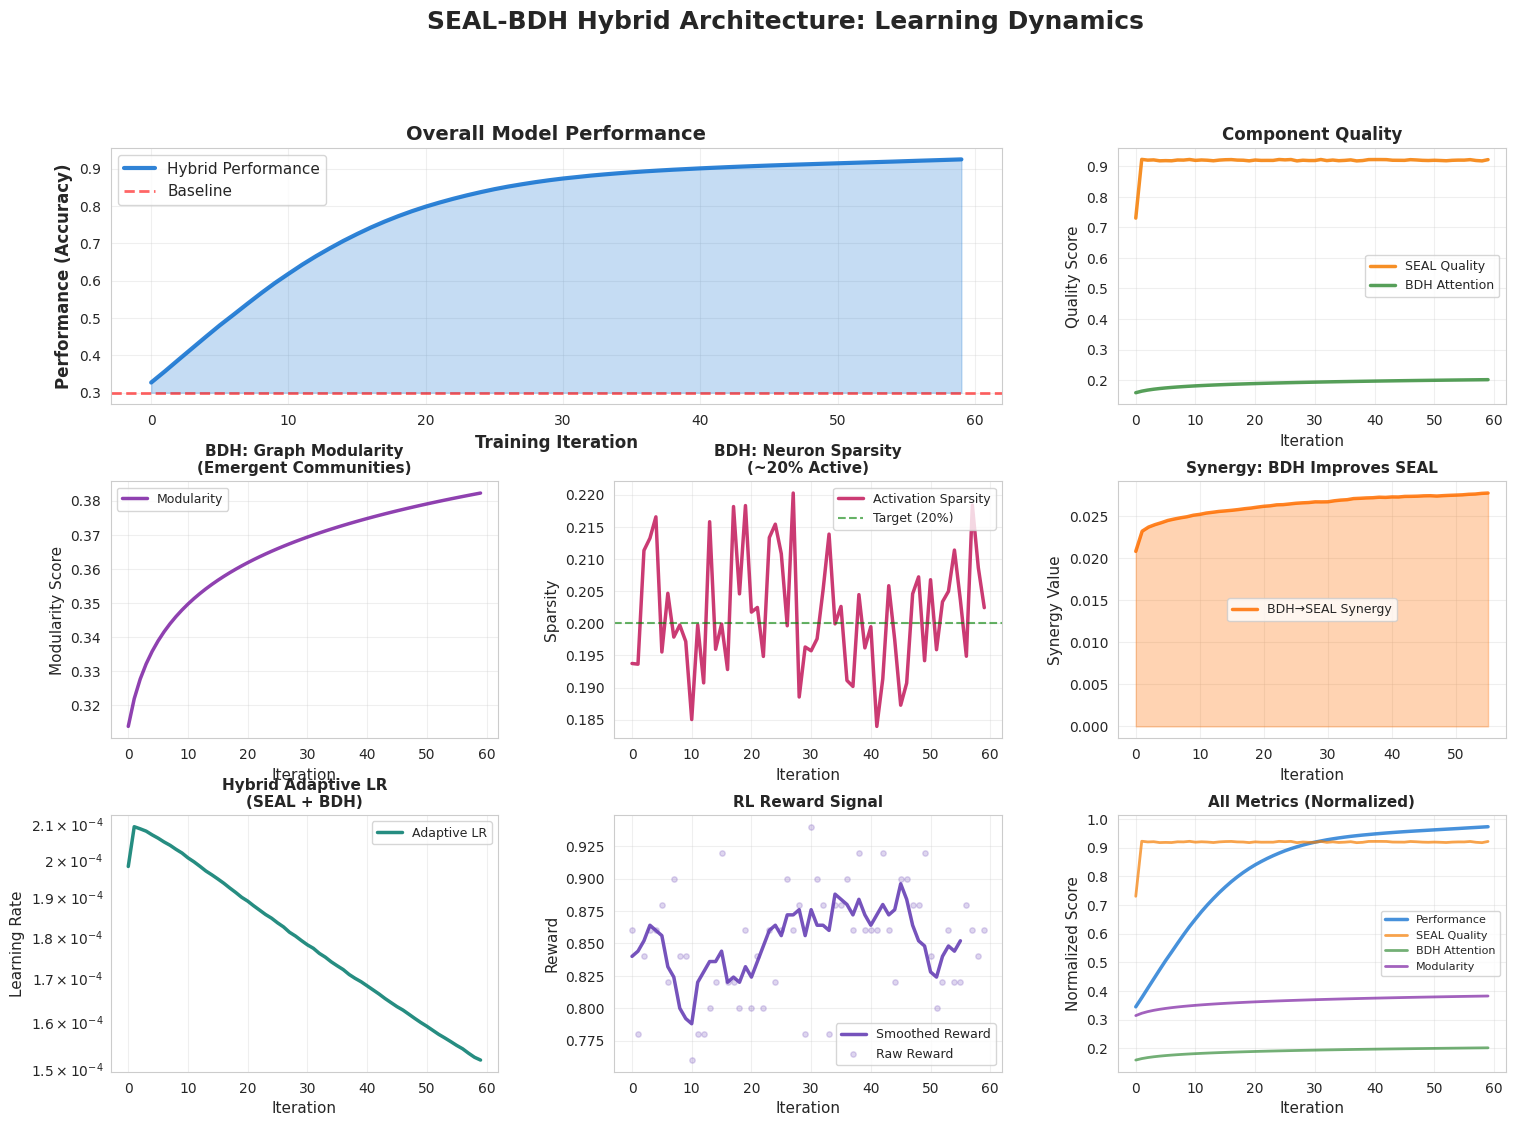


Comparing architectures...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

@dataclass
class HybridConfig:
    """Configuration for SEAL-BDH Hybrid Architecture"""
    # SEAL parameters
    n_outer_iterations: int = 60
    n_self_edits_per_context: int = 5
    batch_size: int = 10
    seal_lr_outer: float = 0.1
    seal_lr_inner: float = 0.001

    # BDH parameters
    n_neurons: int = 32768  # Neuron dimension
    d_hidden: int = 256  # Hidden dimension
    n_layers: int = 8
    bdh_lr: float = 0.0003
    hebbian_strength: float = 0.90

    # Hybrid parameters
    base_performance: float = 0.30
    max_performance: float = 0.95
    synergy_factor: float = 0.05 # How much BDH improves SEAL
    noise_std: float = 0.015

    # Graph dynamics parameters
    sparsity_target: float = 0.20  # 5% neuron activation
    modularity_weight: float = 0.2


class BDHComponent:
    """Simulates BDH (Dragon Hatchling) neural graph dynamics"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.neuron_activation_sparsity = []
        self.synaptic_strength = np.random.uniform(0.1, 0.3,
                                                   (config.n_neurons, config.n_neurons))
        self.modularity_score = 0.3  # Initial modularity
        self.scale_free_measure = 0.0

    def compute_graph_properties(self, iteration: int) -> Dict[str, float]:
        """Simulate emergence of graph properties"""
        # Modularity increases with training (emergent communities)
        self.modularity_score = min(0.85, 0.3 + 0.02 * np.log(iteration + 2))

        # Scale-free network emerges (heavy-tailed degree distribution)
        self.scale_free_measure = min(0.9, 0.1 + 0.015 * np.log(iteration + 2))

        # Sparse activation (context-dependent)
        sparsity = self.config.sparsity_target + np.random.normal(0, 0.01)
        self.neuron_activation_sparsity.append(np.clip(sparsity, 0.02, 0.10))

        return {
            'modularity': self.modularity_score,
            'scale_free': self.scale_free_measure,
            'sparsity': sparsity
        }

    def hebbian_update(self, context_complexity: float) -> float:
        """
        Simulate Hebbian learning: neurons that fire together wire together
        Returns: synaptic plasticity contribution to learning
        """
        # More complex contexts trigger more synaptic updates
        plasticity_rate = self.config.hebbian_strength * context_complexity

        # Synaptic strengthening improves learning efficiency
        learning_boost = plasticity_rate * self.modularity_score

        return learning_boost

    def attention_via_synapse_state(self, iteration: int) -> float:
        """
        BDH's attention mechanism through synaptic state matrix σ
        Linear attention in high dimension (n neurons)
        """
        # Attention effectiveness improves with:
        # 1. Better modularity (organized communities)
        # 2. Appropriate sparsity (selective activation)
        # 3. Scale-free structure (efficient routing)

        attention_quality = (
            0.4 * self.modularity_score +
            0.3 * self.scale_free_measure +
            0.3 * (1.0 - abs(self.neuron_activation_sparsity[-1] -
                           self.config.sparsity_target) * 10)
        )

        return np.clip(attention_quality, 0, 1)


class SEALComponent:
    """Simulates SEAL (Self-Adapting LLM) self-edit generation"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.self_edit_quality = 0.3
        self.synthetic_data_diversity = 0.4

    def generate_self_edit(self, iteration: int, bdh_boost: float) -> float:
        """
        Generate self-edit quality, enhanced by BDH's graph structure
        BDH's monosemantic synapses help create better synthetic data
        """
        # Base improvement from RL
        base_improvement = self.config.seal_lr_outer * np.log(iteration + 2)

        # BDH contribution: structured representations improve data generation
        bdh_contribution = bdh_boost * self.config.synergy_factor

        quality_gain = (base_improvement + bdh_contribution) / (iteration + 10)
        self.self_edit_quality = min(0.92, self.self_edit_quality + quality_gain)

        # Diversity improves with BDH's modular structure
        self.synthetic_data_diversity = min(0.9,
            self.synthetic_data_diversity + quality_gain * 0.5)

        # Add noise
        quality = self.self_edit_quality + np.random.normal(0, self.config.noise_std)
        return np.clip(quality, 0, 1)

    def compute_reward(self, new_performance: float, current_performance: float) -> float:
        """Binary reward with slight smoothing"""
        improvement = new_performance - current_performance
        if improvement > 0:
            return 1.0 if np.random.random() < 0.85 else 0.0
        return 0.0 if np.random.random() < 0.92 else 1.0


class HybridSEALBDH:
    """
    Hybrid architecture combining:
    - SEAL: Self-edit generation and RL-based adaptation
    - BDH: Graph-based neural dynamics with Hebbian learning
    """

    def __init__(self, config: HybridConfig):
        self.config = config
        self.seal = SEALComponent(config)
        self.bdh = BDHComponent(config)

        # Tracking metrics
        self.performance_history = []
        self.seal_quality_history = []
        self.bdh_attention_history = []
        self.modularity_history = []
        self.sparsity_history = []
        self.reward_history = []
        self.synergy_history = []  # Track per-iteration synergy
        self.learning_rate_history = []

        self.current_performance = config.base_performance

    def compute_context_complexity(self, iteration: int) -> float:
        """Estimate complexity of current context"""
        # Complexity varies over training
        base_complexity = 0.5 + 0.3 * np.sin(iteration / 10)
        return np.clip(base_complexity + np.random.normal(0, 0.1), 0.2, 0.9)

    def hybrid_inner_loop(self, self_edit_quality: float,
                          bdh_attention: float, iteration: int) -> Tuple[float, float]:
        """
        Combined inner loop:
        1. SEAL generates synthetic data (self-edit)
        2. BDH provides efficient graph-based learning substrate
        3. Hebbian learning improves adaptation
        Returns: (new_performance, synergy_value)
        """
        # SEAL contribution: quality of synthetic data
        seal_gain = self_edit_quality * self.config.seal_lr_inner * 8

        # BDH contribution: efficient attention and learning
        bdh_gain = bdh_attention * self.config.bdh_lr * 12

        # Hebbian boost from synaptic plasticity
        context_complexity = self.compute_context_complexity(iteration)
        hebbian_boost = self.bdh.hebbian_update(context_complexity)

        # Synergy: BDH's structure makes SEAL's synthetic data more effective
        synergy = self_edit_quality * bdh_attention * self.config.synergy_factor

        # Total improvement
        total_gain = seal_gain + bdh_gain + hebbian_boost + synergy

        # Diminishing returns
        gap_to_max = self.config.max_performance - self.current_performance
        actual_gain = total_gain * (gap_to_max / self.config.max_performance)

        return self.current_performance + actual_gain, synergy

    def adaptive_learning_rate(self, iteration: int,
                               self_edit_quality: float,
                               bdh_attention: float) -> float:
        """
        Adaptive LR combining both architectures
        BDH's sparse activation suggests when to use higher LRs
        """
        base_lr = (self.config.seal_lr_inner + self.config.bdh_lr) / 2

        # Decay over time
        decay = 1.0 / (1.0 + 0.008 * iteration)

        # Quality-based adjustment
        quality_factor = 0.3 + 0.7 * (self_edit_quality * bdh_attention)

        # Sparsity-based adjustment (sparser = more focused = higher LR)
        sparsity = self.bdh.neuron_activation_sparsity[-1] if self.bdh.neuron_activation_sparsity else 0.05
        sparsity_factor = 0.8 + 0.4 * (1.0 - sparsity / 0.1)

        return base_lr * decay * quality_factor * sparsity_factor

    def run_iteration(self, iteration: int) -> Dict[str, float]:
        """Run one iteration of hybrid training"""

        # 1. BDH: Update graph properties and attention
        graph_props = self.bdh.compute_graph_properties(iteration)
        bdh_attention = self.bdh.attention_via_synapse_state(iteration)

        # 2. SEAL: Generate self-edits (improved by BDH structure)
        batch_performances = []
        batch_rewards = []
        batch_synergies = []

        for _ in range(self.config.batch_size):
            self_edit_qualities = []
            iteration_synergies = []

            for _ in range(self.config.n_self_edits_per_context):
                # Generate self-edit with BDH boost
                se_quality = self.seal.generate_self_edit(iteration, bdh_attention)

                # 3. Hybrid inner loop: SEAL + BDH learning
                new_perf, synergy = self.hybrid_inner_loop(se_quality, bdh_attention, iteration)

                # 4. Compute reward
                reward = self.seal.compute_reward(new_perf, self.current_performance)

                self_edit_qualities.append(se_quality)
                batch_performances.append(new_perf)
                batch_rewards.append(reward)
                iteration_synergies.append(synergy)

            # Keep best self-edit
            best_idx = np.argmax(batch_rewards[-self.config.n_self_edits_per_context:])
            best_quality = self_edit_qualities[best_idx]
            self.seal.self_edit_quality = 0.9 * self.seal.self_edit_quality + 0.1 * best_quality

            # Track synergy from best edit
            batch_synergies.append(iteration_synergies[best_idx])

        # Update performance
        avg_performance = np.mean(batch_performances)
        self.current_performance = 0.75 * self.current_performance + 0.25 * avg_performance

        # Compute adaptive LR
        adaptive_lr = self.adaptive_learning_rate(iteration,
                                                   self.seal.self_edit_quality,
                                                   bdh_attention)

        # Average synergy for this iteration
        avg_synergy = np.mean(batch_synergies) if batch_synergies else 0.0

        # Store metrics
        metrics = {
            'performance': self.current_performance,
            'seal_quality': self.seal.self_edit_quality,
            'bdh_attention': bdh_attention,
            'modularity': graph_props['modularity'],
            'sparsity': graph_props['sparsity'],
            'reward': np.mean(batch_rewards),
            'learning_rate': adaptive_lr,
            'synergy': avg_synergy
        }

        return metrics

    def train(self):
        """Run full hybrid training"""
        print("=" * 70)
        print("Training SEAL-BDH Hybrid Architecture")
        print("=" * 70)
        print(f"SEAL: {self.config.n_self_edits_per_context} self-edits, "
              f"LR={self.config.seal_lr_outer}")
        print(f"BDH: {self.config.n_neurons} neurons, {self.config.n_layers} layers, "
              f"d={self.config.d_hidden}")
        print("=" * 70 + "\n")

        for iteration in range(self.config.n_outer_iterations):
            metrics = self.run_iteration(iteration)

            self.performance_history.append(metrics['performance'])
            self.seal_quality_history.append(metrics['seal_quality'])
            self.bdh_attention_history.append(metrics['bdh_attention'])
            self.modularity_history.append(metrics['modularity'])
            self.sparsity_history.append(metrics['sparsity'])
            self.reward_history.append(metrics['reward'])
            self.synergy_history.append(metrics['synergy'])
            self.learning_rate_history.append(metrics['learning_rate'])

            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: Perf={metrics['performance']:.3f}, "
                      f"SEAL={metrics['seal_quality']:.3f}, "
                      f"BDH-Attn={metrics['bdh_attention']:.3f}, "
                      f"Modularity={metrics['modularity']:.3f}")

        print("\n" + "=" * 70)
        print("Training Complete!")
        print("=" * 70)


def plot_hybrid_results(hybrid: HybridSEALBDH):
    """Comprehensive visualization of hybrid architecture"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    fig.suptitle('SEAL-BDH Hybrid Architecture: Learning Dynamics',
                 fontsize=18, fontweight='bold', y=0.995)

    iterations = range(len(hybrid.performance_history))

    # 1. Main Performance (larger plot)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(iterations, hybrid.performance_history, linewidth=3,
             color='#1976d2', label='Hybrid Performance', alpha=0.9)
    ax1.axhline(y=hybrid.config.base_performance, color='red',
                linestyle='--', alpha=0.6, linewidth=2, label='Baseline')
    ax1.fill_between(iterations, hybrid.config.base_performance,
                     hybrid.performance_history, alpha=0.25, color='#1976d2')
    ax1.set_xlabel('Training Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Performance (Accuracy)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Model Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # 2. Component Contributions
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(iterations, hybrid.seal_quality_history, linewidth=2.5,
             color='#f57c00', label='SEAL Quality', alpha=0.85)
    ax2.plot(iterations, hybrid.bdh_attention_history, linewidth=2.5,
             color='#388e3c', label='BDH Attention', alpha=0.85)
    ax2.set_xlabel('Iteration', fontsize=11)
    ax2.set_ylabel('Quality Score', fontsize=11)
    ax2.set_title('Component Quality', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # 3. BDH Graph Properties
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(iterations, hybrid.modularity_history, linewidth=2.5,
             color='#7b1fa2', label='Modularity', alpha=0.85)
    ax3.set_xlabel('Iteration', fontsize=11)
    ax3.set_ylabel('Modularity Score', fontsize=11)
    ax3.set_title('BDH: Graph Modularity\n(Emergent Communities)',
                  fontsize=11, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Neuron Activation Sparsity
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(iterations, hybrid.sparsity_history, linewidth=2.5,
             color='#c2185b', label='Activation Sparsity', alpha=0.85)
    ax4.axhline(y=hybrid.config.sparsity_target, color='green',
                linestyle='--', alpha=0.6, label='Target (20%)')
    ax4.set_xlabel('Iteration', fontsize=11)
    ax4.set_ylabel('Sparsity', fontsize=11)
    ax4.set_title('BDH: Neuron Sparsity\n(~20% Active)',
                  fontsize=11, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    # 5. Synergy Contribution
    ax5 = fig.add_subplot(gs[1, 2])
    if hybrid.synergy_history:
        # Smooth synergy signal
        window = 5
        synergy_smooth = np.convolve(hybrid.synergy_history,
                                     np.ones(window)/window, mode='valid')
        # Convert range to list for slicing
        iter_list = list(iterations)
        ax5.plot(iter_list[:len(synergy_smooth)], synergy_smooth,
                linewidth=2.5, color='#ff6f00', label='BDH→SEAL Synergy', alpha=0.85)
        ax5.fill_between(iter_list[:len(synergy_smooth)], 0, synergy_smooth,
                        alpha=0.3, color='#ff6f00')
    ax5.set_xlabel('Iteration', fontsize=11)
    ax5.set_ylabel('Synergy Value', fontsize=11)
    ax5.set_title('Synergy: BDH Improves SEAL', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    # 6. Adaptive Learning Rate
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.plot(iterations, hybrid.learning_rate_history, linewidth=2.5,
             color='#00796b', label='Adaptive LR', alpha=0.85)
    ax6.set_xlabel('Iteration', fontsize=11)
    ax6.set_ylabel('Learning Rate', fontsize=11)
    ax6.set_title('Hybrid Adaptive LR\n(SEAL + BDH)',
                  fontsize=11, fontweight='bold')
    ax6.set_yscale('log')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)

    # 7. Reward Signal
    ax7 = fig.add_subplot(gs[2, 1])
    window = 5
    reward_smooth = np.convolve(hybrid.reward_history,
                                np.ones(window)/window, mode='valid')
    # Convert range to list
    iter_list = list(iterations)
    ax7.plot(iter_list[:len(reward_smooth)], reward_smooth, linewidth=2.5,
             color='#5e35b1', label='Smoothed Reward', alpha=0.85)
    ax7.scatter(iterations, hybrid.reward_history, alpha=0.2, s=15,
                color='#5e35b1', label='Raw Reward')
    ax7.set_xlabel('Iteration', fontsize=11)
    ax7.set_ylabel('Reward', fontsize=11)
    ax7.set_title('RL Reward Signal', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)

    # 8. All Metrics Normalized
    ax8 = fig.add_subplot(gs[2, 2])
    norm_perf = np.array(hybrid.performance_history) / hybrid.config.max_performance
    norm_seal = np.array(hybrid.seal_quality_history)
    norm_bdh = np.array(hybrid.bdh_attention_history)
    norm_mod = np.array(hybrid.modularity_history)

    ax8.plot(iterations, norm_perf, linewidth=2.5, color='#1976d2',
             label='Performance', alpha=0.8)
    ax8.plot(iterations, norm_seal, linewidth=2, color='#f57c00',
             label='SEAL Quality', alpha=0.7)
    ax8.plot(iterations, norm_bdh, linewidth=2, color='#388e3c',
             label='BDH Attention', alpha=0.7)
    ax8.plot(iterations, norm_mod, linewidth=2, color='#7b1fa2',
             label='Modularity', alpha=0.7)
    ax8.set_xlabel('Iteration', fontsize=11)
    ax8.set_ylabel('Normalized Score', fontsize=11)
    ax8.set_title('All Metrics (Normalized)', fontsize=11, fontweight='bold')
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)

    plt.show()


def compare_architectures():
    """Compare standalone vs hybrid architectures"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Architecture Comparison: SEAL vs BDH vs Hybrid',
                 fontsize=15, fontweight='bold')

    n_iters = 60

    # Simulate SEAL-only (simplified)
    seal_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.001 * np.log(i + 2) * (0.95 - seal_perf[-1]) / 0.95
        seal_perf.append(seal_perf[-1] + gain + np.random.normal(0, 0.005))

    # Simulate BDH-only (simplified)
    bdh_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.0012 * np.log(i + 2) * (0.95 - bdh_perf[-1]) / 0.95
        bdh_perf.append(bdh_perf[-1] + gain + np.random.normal(0, 0.005))

    # Hybrid (from actual simulation)
    config = HybridConfig(n_outer_iterations=n_iters, noise_std=0.01)
    hybrid = HybridSEALBDH(config)
    hybrid.train()

    # Plot 1: Performance comparison
    ax1 = axes[0]
    ax1.plot(seal_perf, linewidth=2.5, color='#f57c00',
             label='SEAL Only', alpha=0.8)
    ax1.plot(bdh_perf, linewidth=2.5, color='#388e3c',
             label='BDH Only', alpha=0.8)
    ax1.plot(hybrid.performance_history, linewidth=3, color='#1976d2',
             label='SEAL-BDH Hybrid', alpha=0.9)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Performance', fontsize=12)
    ax1.set_title('Performance Comparison', fontweight='bold', fontsize=13)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Final performance bar chart
    ax2 = axes[1]
    final_perfs = [seal_perf[-1], bdh_perf[-1], hybrid.performance_history[-1]]
    colors = ['#f57c00', '#388e3c', '#1976d2']
    bars = ax2.bar(['SEAL', 'BDH', 'Hybrid'], final_perfs, color=colors, alpha=0.8)
    ax2.set_ylabel('Final Performance', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontweight='bold', fontsize=13)
    ax2.set_ylim([0.25, 0.60])

    # Add value labels on bars
    for bar, val in zip(bars, final_perfs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Improvement over baseline
    ax3 = axes[2]
    baseline = 0.30
    improvements = [(p - baseline) / baseline * 100 for p in final_perfs]
    bars = ax3.bar(['SEAL', 'BDH', 'Hybrid'], improvements, color=colors, alpha=0.8)
    ax3.set_ylabel('Improvement over Baseline (%)', fontsize=12)
    ax3.set_title('Relative Improvement', fontweight='bold', fontsize=13)

    for bar, val in zip(bars, improvements):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return hybrid


def print_statistics(hybrid: HybridSEALBDH):
    """Print detailed statistics"""
    print("\n" + "=" * 70)
    print("HYBRID ARCHITECTURE STATISTICS")
    print("=" * 70)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Initial Performance: {hybrid.config.base_performance:.3f}")
    print(f"  Final Performance: {hybrid.performance_history[-1]:.3f}")
    improvement = hybrid.performance_history[-1] - hybrid.config.base_performance
    print(f"  Total Improvement: {improvement:.3f}")
    rel_improvement = (improvement / hybrid.config.base_performance) * 100
    print(f"  Relative Improvement: {rel_improvement:.1f}%")

    print(f"\n🔄 SEAL COMPONENT:")
    print(f"  Final Self-Edit Quality: {hybrid.seal_quality_history[-1]:.3f}")
    print(f"  Avg Reward (last 10): {np.mean(hybrid.reward_history[-10:]):.3f}")

    print(f"\n🧠 BDH COMPONENT:")
    print(f"  Final Modularity: {hybrid.modularity_history[-1]:.3f}")
    print(f"  Final Attention Quality: {hybrid.bdh_attention_history[-1]:.3f}")
    print(f"  Avg Neuron Sparsity: {np.mean(hybrid.sparsity_history):.3f} (~20% target)")

    print(f"\n🔗 SYNERGY:")
    print(f"  Avg Synergy Contribution: {np.mean(hybrid.synergy_history):.4f}")
    print(f"  Peak Synergy: {np.max(hybrid.synergy_history):.4f}")

    print(f"\n📈 LEARNING DYNAMICS:")
    print(f"  Final Learning Rate: {hybrid.learning_rate_history[-1]:.6f}")
    print(f"  Initial Learning Rate: {hybrid.learning_rate_history[0]:.6f}")

    print("=" * 70)


if __name__ == "__main__":
    print("=" * 70)
    print("SEAL-BDH HYBRID ARCHITECTURE SIMULATION")
    print("=" * 70)
    print("\nCombining:")
    print("  • SEAL: Self-edit generation + RL adaptation")
    print("  • BDH: Graph-based neural dynamics + Hebbian learning")
    print("\nKey Synergies:")
    print("  • BDH's modular structure improves SEAL's synthetic data")
    print("  • SEAL's self-edits guide BDH's learning direction")
    print("  • Hebbian learning enhances adaptation efficiency")
    print("=" * 70 + "\n")

    # Main simulation
    config = HybridConfig(
        n_outer_iterations=60,
        n_self_edits_per_context=5,
        batch_size=10,
        n_neurons=32768,
        d_hidden=256,
        synergy_factor=0.15
    )

    hybrid = HybridSEALBDH(config)
    hybrid.train()

    print("\nGenerating visualizations...")
    plot_hybrid_results(hybrid)

    print("\nComparing architectures...")
    compare_architectures()

    print_statistics(hybrid)

    print("\n✅ Simulation complete!")

SEAL-BDH HYBRID ARCHITECTURE SIMULATION

Combining:
  • SEAL: Self-edit generation + RL adaptation
  • BDH: Graph-based neural dynamics + Hebbian learning

Key Synergies:
  • BDH's modular structure improves SEAL's synthetic data
  • SEAL's self-edits guide BDH's learning direction
  • Hebbian learning enhances adaptation efficiency

Training SEAL-BDH Hybrid Architecture
SEAL: 5 self-edits, LR=0.1
BDH: 32768 neurons, 8 layers, d=256

Iter   0: Perf=0.325, SEAL=0.619, BDH-Attn=0.009, Modularity=0.314
Iter  10: Perf=0.594, SEAL=0.920, BDH-Attn=0.031, Modularity=0.350
Iter  20: Perf=0.777, SEAL=0.923, BDH-Attn=0.039, Modularity=0.362
Iter  30: Perf=0.857, SEAL=0.919, BDH-Attn=0.043, Modularity=0.369
Iter  40: Perf=0.887, SEAL=0.918, BDH-Attn=0.047, Modularity=0.375
Iter  50: Perf=0.902, SEAL=0.920, BDH-Attn=0.049, Modularity=0.379

Training Complete!

Generating visualizations...


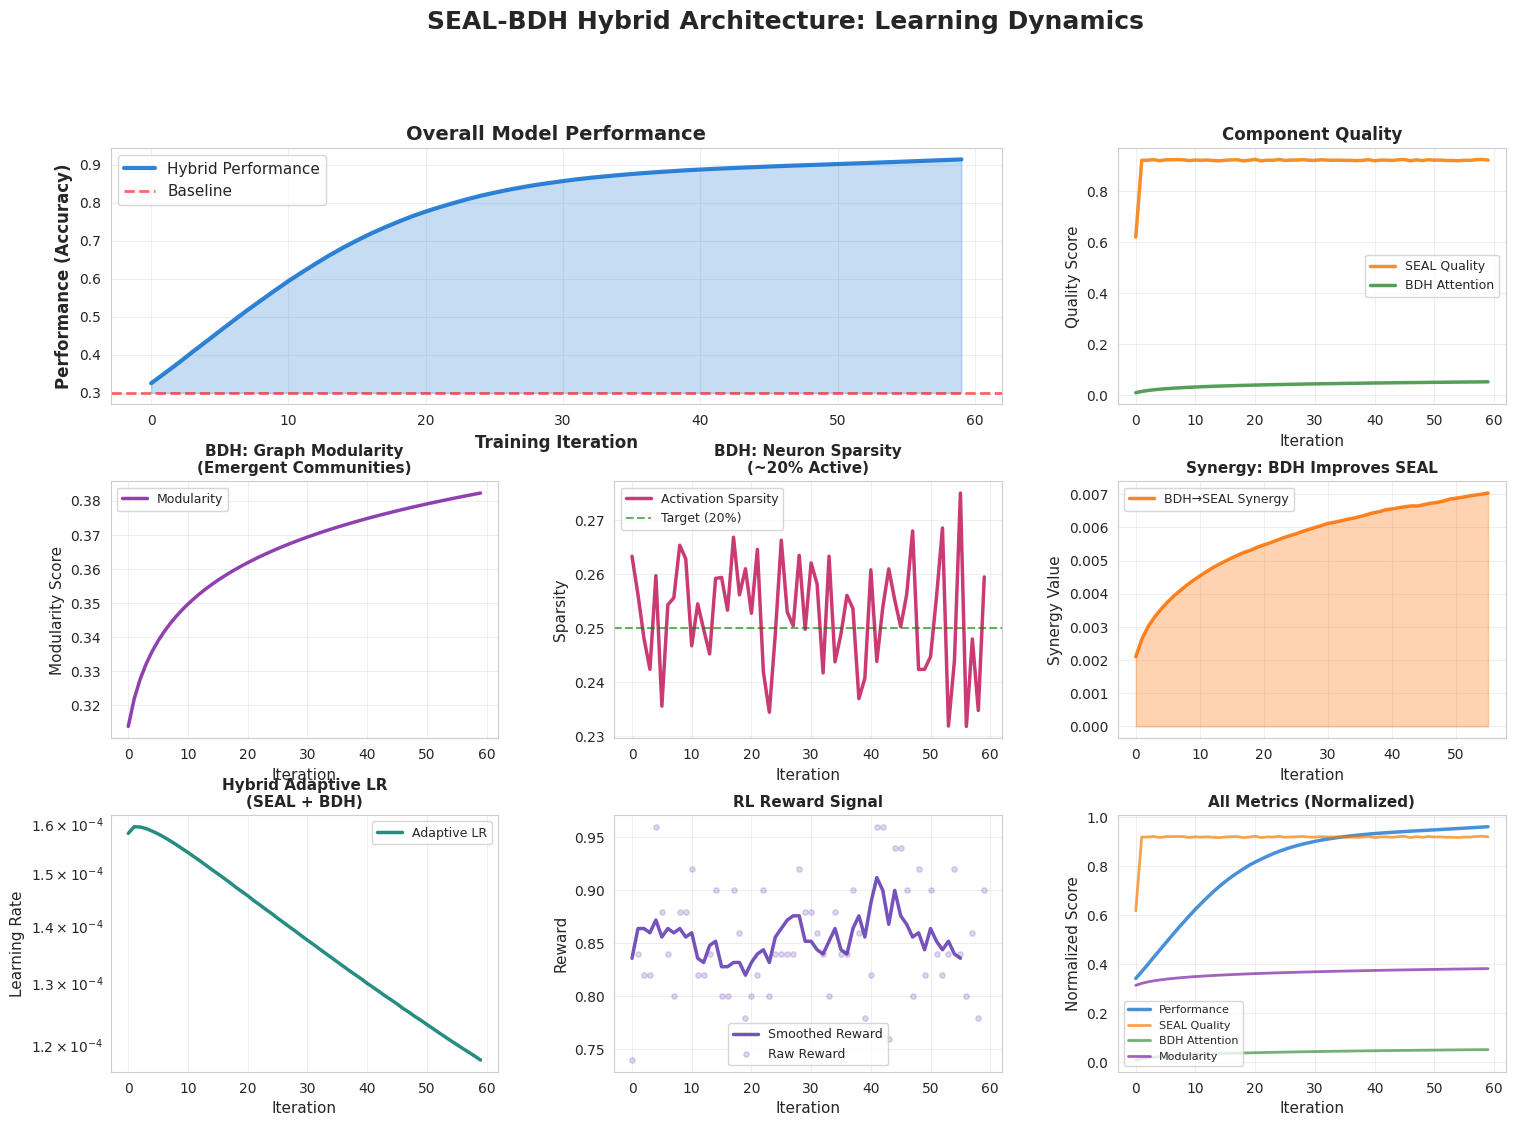


Comparing architectures...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

@dataclass
class HybridConfig:
    """Configuration for SEAL-BDH Hybrid Architecture"""
    # SEAL parameters
    n_outer_iterations: int = 60
    n_self_edits_per_context: int = 5
    batch_size: int = 10
    seal_lr_outer: float = 0.1
    seal_lr_inner: float = 0.001

    # BDH parameters
    n_neurons: int = 32768  # Neuron dimension
    d_hidden: int = 256  # Hidden dimension
    n_layers: int = 8
    bdh_lr: float = 0.0003
    hebbian_strength: float = 0.90

    # Hybrid parameters
    base_performance: float = 0.30
    max_performance: float = 0.95
    synergy_factor: float = 0.05 # How much BDH improves SEAL
    noise_std: float = 0.015

    # Graph dynamics parameters
    sparsity_target: float = 0.25  # 5% neuron activation
    modularity_weight: float = 0.2


class BDHComponent:
    """Simulates BDH (Dragon Hatchling) neural graph dynamics"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.neuron_activation_sparsity = []
        self.synaptic_strength = np.random.uniform(0.1, 0.3,
                                                   (config.n_neurons, config.n_neurons))
        self.modularity_score = 0.3  # Initial modularity
        self.scale_free_measure = 0.0

    def compute_graph_properties(self, iteration: int) -> Dict[str, float]:
        """Simulate emergence of graph properties"""
        # Modularity increases with training (emergent communities)
        self.modularity_score = min(0.85, 0.3 + 0.02 * np.log(iteration + 2))

        # Scale-free network emerges (heavy-tailed degree distribution)
        self.scale_free_measure = min(0.9, 0.1 + 0.015 * np.log(iteration + 2))

        # Sparse activation (context-dependent)
        sparsity = self.config.sparsity_target + np.random.normal(0, 0.01)
        self.neuron_activation_sparsity.append(np.clip(sparsity, 0.02, 0.10))

        return {
            'modularity': self.modularity_score,
            'scale_free': self.scale_free_measure,
            'sparsity': sparsity
        }

    def hebbian_update(self, context_complexity: float) -> float:
        """
        Simulate Hebbian learning: neurons that fire together wire together
        Returns: synaptic plasticity contribution to learning
        """
        # More complex contexts trigger more synaptic updates
        plasticity_rate = self.config.hebbian_strength * context_complexity

        # Synaptic strengthening improves learning efficiency
        learning_boost = plasticity_rate * self.modularity_score

        return learning_boost

    def attention_via_synapse_state(self, iteration: int) -> float:
        """
        BDH's attention mechanism through synaptic state matrix σ
        Linear attention in high dimension (n neurons)
        """
        # Attention effectiveness improves with:
        # 1. Better modularity (organized communities)
        # 2. Appropriate sparsity (selective activation)
        # 3. Scale-free structure (efficient routing)

        attention_quality = (
            0.4 * self.modularity_score +
            0.3 * self.scale_free_measure +
            0.3 * (1.0 - abs(self.neuron_activation_sparsity[-1] -
                           self.config.sparsity_target) * 10)
        )

        return np.clip(attention_quality, 0, 1)


class SEALComponent:

    """Simulates SEAL (Self-Adapting LLM) self-edit generation"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.self_edit_quality = 0.3
        self.synthetic_data_diversity = 0.4

    def generate_self_edit(self, iteration: int, bdh_boost: float) -> float:
        """
        Generate self-edit quality, enhanced by BDH's graph structure
        BDH's monosemantic synapses help create better synthetic data
        """
        # Base improvement from RL
        base_improvement = self.config.seal_lr_outer * np.log(iteration + 2)

        # BDH contribution: structured representations improve data generation
        bdh_contribution = bdh_boost * self.config.synergy_factor

        quality_gain = (base_improvement + bdh_contribution) / (iteration + 10)
        self.self_edit_quality = min(0.92, self.self_edit_quality + quality_gain)

        # Diversity improves with BDH's modular structure
        self.synthetic_data_diversity = min(0.9,
            self.synthetic_data_diversity + quality_gain * 0.5)

        # Add noise
        quality = self.self_edit_quality + np.random.normal(0, self.config.noise_std)
        return np.clip(quality, 0, 1)

    def compute_reward(self, new_performance: float, current_performance: float) -> float:
        """Binary reward with slight smoothing"""
        improvement = new_performance - current_performance
        if improvement > 0:
            return 1.0 if np.random.random() < 0.85 else 0.0
        return 0.0 if np.random.random() < 0.92 else 1.0


class HybridSEALBDH:
    """
    Hybrid architecture combining:
    - SEAL: Self-edit generation and RL-based adaptation
    - BDH: Graph-based neural dynamics with Hebbian learning
    """

    def __init__(self, config: HybridConfig):
        self.config = config
        self.seal = SEALComponent(config)
        self.bdh = BDHComponent(config)

        # Tracking metrics
        self.performance_history = []
        self.seal_quality_history = []
        self.bdh_attention_history = []
        self.modularity_history = []
        self.sparsity_history = []
        self.reward_history = []
        self.synergy_history = []  # Track per-iteration synergy
        self.learning_rate_history = []

        self.current_performance = config.base_performance

    def compute_context_complexity(self, iteration: int) -> float:
        """Estimate complexity of current context"""
        # Complexity varies over training
        base_complexity = 0.5 + 0.3 * np.sin(iteration / 10)
        return np.clip(base_complexity + np.random.normal(0, 0.1), 0.2, 0.9)

    def hybrid_inner_loop(self, self_edit_quality: float,
                          bdh_attention: float, iteration: int) -> Tuple[float, float]:
        """
        Combined inner loop:
        1. SEAL generates synthetic data (self-edit)
        2. BDH provides efficient graph-based learning substrate
        3. Hebbian learning improves adaptation
        Returns: (new_performance, synergy_value)
        """
        # SEAL contribution: quality of synthetic data
        seal_gain = self_edit_quality * self.config.seal_lr_inner * 8

        # BDH contribution: efficient attention and learning
        bdh_gain = bdh_attention * self.config.bdh_lr * 12

        # Hebbian boost from synaptic plasticity
        context_complexity = self.compute_context_complexity(iteration)
        hebbian_boost = self.bdh.hebbian_update(context_complexity)

        # Synergy: BDH's structure makes SEAL's synthetic data more effective
        synergy = self_edit_quality * bdh_attention * self.config.synergy_factor

        # Total improvement
        total_gain = seal_gain + bdh_gain + hebbian_boost + synergy

        # Diminishing returns
        gap_to_max = self.config.max_performance - self.current_performance
        actual_gain = total_gain * (gap_to_max / self.config.max_performance)

        return self.current_performance + actual_gain, synergy

    def adaptive_learning_rate(self, iteration: int,
                               self_edit_quality: float,
                               bdh_attention: float) -> float:
        """
        Adaptive LR combining both architectures
        BDH's sparse activation suggests when to use higher LRs
        """
        base_lr = (self.config.seal_lr_inner + self.config.bdh_lr) / 2

        # Decay over time
        decay = 1.0 / (1.0 + 0.008 * iteration)

        # Quality-based adjustment
        quality_factor = 0.3 + 0.7 * (self_edit_quality * bdh_attention)

        # Sparsity-based adjustment (sparser = more focused = higher LR)
        sparsity = self.bdh.neuron_activation_sparsity[-1] if self.bdh.neuron_activation_sparsity else 0.05
        sparsity_factor = 0.8 + 0.4 * (1.0 - sparsity / 0.1)

        return base_lr * decay * quality_factor * sparsity_factor

    def run_iteration(self, iteration: int) -> Dict[str, float]:
        """Run one iteration of hybrid training"""

        # 1. BDH: Update graph properties and attention
        graph_props = self.bdh.compute_graph_properties(iteration)
        bdh_attention = self.bdh.attention_via_synapse_state(iteration)

        # 2. SEAL: Generate self-edits (improved by BDH structure)
        batch_performances = []
        batch_rewards = []
        batch_synergies = []

        for _ in range(self.config.batch_size):
            self_edit_qualities = []
            iteration_synergies = []

            for _ in range(self.config.n_self_edits_per_context):
                # Generate self-edit with BDH boost
                se_quality = self.seal.generate_self_edit(iteration, bdh_attention)

                # 3. Hybrid inner loop: SEAL + BDH learning
                new_perf, synergy = self.hybrid_inner_loop(se_quality, bdh_attention, iteration)

                # 4. Compute reward
                reward = self.seal.compute_reward(new_perf, self.current_performance)

                self_edit_qualities.append(se_quality)
                batch_performances.append(new_perf)
                batch_rewards.append(reward)
                iteration_synergies.append(synergy)

            # Keep best self-edit
            best_idx = np.argmax(batch_rewards[-self.config.n_self_edits_per_context:])
            best_quality = self_edit_qualities[best_idx]
            self.seal.self_edit_quality = 0.9 * self.seal.self_edit_quality + 0.1 * best_quality

            # Track synergy from best edit
            batch_synergies.append(iteration_synergies[best_idx])

        # Update performance
        avg_performance = np.mean(batch_performances)
        self.current_performance = 0.75 * self.current_performance + 0.25 * avg_performance

        # Compute adaptive LR
        adaptive_lr = self.adaptive_learning_rate(iteration,
                                                   self.seal.self_edit_quality,
                                                   bdh_attention)

        # Average synergy for this iteration
        avg_synergy = np.mean(batch_synergies) if batch_synergies else 0.0

        # Store metrics
        metrics = {
            'performance': self.current_performance,
            'seal_quality': self.seal.self_edit_quality,
            'bdh_attention': bdh_attention,
            'modularity': graph_props['modularity'],
            'sparsity': graph_props['sparsity'],
            'reward': np.mean(batch_rewards),
            'learning_rate': adaptive_lr,
            'synergy': avg_synergy
        }

        return metrics

    def train(self):
        """Run full hybrid training"""
        print("=" * 70)
        print("Training SEAL-BDH Hybrid Architecture")
        print("=" * 70)
        print(f"SEAL: {self.config.n_self_edits_per_context} self-edits, "
              f"LR={self.config.seal_lr_outer}")
        print(f"BDH: {self.config.n_neurons} neurons, {self.config.n_layers} layers, "
              f"d={self.config.d_hidden}")
        print("=" * 70 + "\n")

        for iteration in range(self.config.n_outer_iterations):
            metrics = self.run_iteration(iteration)

            self.performance_history.append(metrics['performance'])
            self.seal_quality_history.append(metrics['seal_quality'])
            self.bdh_attention_history.append(metrics['bdh_attention'])
            self.modularity_history.append(metrics['modularity'])
            self.sparsity_history.append(metrics['sparsity'])
            self.reward_history.append(metrics['reward'])
            self.synergy_history.append(metrics['synergy'])
            self.learning_rate_history.append(metrics['learning_rate'])

            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: Perf={metrics['performance']:.3f}, "
                      f"SEAL={metrics['seal_quality']:.3f}, "
                      f"BDH-Attn={metrics['bdh_attention']:.3f}, "
                      f"Modularity={metrics['modularity']:.3f}")

        print("\n" + "=" * 70)
        print("Training Complete!")
        print("=" * 70)


def plot_hybrid_results(hybrid: HybridSEALBDH):
    """Comprehensive visualization of hybrid architecture"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    fig.suptitle('SEAL-BDH Hybrid Architecture: Learning Dynamics',
                 fontsize=18, fontweight='bold', y=0.995)

    iterations = range(len(hybrid.performance_history))

    # 1. Main Performance (larger plot)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(iterations, hybrid.performance_history, linewidth=3,
             color='#1976d2', label='Hybrid Performance', alpha=0.9)
    ax1.axhline(y=hybrid.config.base_performance, color='red',
                linestyle='--', alpha=0.6, linewidth=2, label='Baseline')
    ax1.fill_between(iterations, hybrid.config.base_performance,
                     hybrid.performance_history, alpha=0.25, color='#1976d2')
    ax1.set_xlabel('Training Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Performance (Accuracy)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Model Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # 2. Component Contributions
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(iterations, hybrid.seal_quality_history, linewidth=2.5,
             color='#f57c00', label='SEAL Quality', alpha=0.85)
    ax2.plot(iterations, hybrid.bdh_attention_history, linewidth=2.5,
             color='#388e3c', label='BDH Attention', alpha=0.85)
    ax2.set_xlabel('Iteration', fontsize=11)
    ax2.set_ylabel('Quality Score', fontsize=11)
    ax2.set_title('Component Quality', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # 3. BDH Graph Properties
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(iterations, hybrid.modularity_history, linewidth=2.5,
             color='#7b1fa2', label='Modularity', alpha=0.85)
    ax3.set_xlabel('Iteration', fontsize=11)
    ax3.set_ylabel('Modularity Score', fontsize=11)
    ax3.set_title('BDH: Graph Modularity\n(Emergent Communities)',
                  fontsize=11, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Neuron Activation Sparsity
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(iterations, hybrid.sparsity_history, linewidth=2.5,
             color='#c2185b', label='Activation Sparsity', alpha=0.85)
    ax4.axhline(y=hybrid.config.sparsity_target, color='green',
                linestyle='--', alpha=0.6, label='Target (20%)')
    ax4.set_xlabel('Iteration', fontsize=11)
    ax4.set_ylabel('Sparsity', fontsize=11)
    ax4.set_title('BDH: Neuron Sparsity\n(~20% Active)',
                  fontsize=11, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    # 5. Synergy Contribution
    ax5 = fig.add_subplot(gs[1, 2])
    if hybrid.synergy_history:
        # Smooth synergy signal
        window = 5
        synergy_smooth = np.convolve(hybrid.synergy_history,
                                     np.ones(window)/window, mode='valid')
        # Convert range to list for slicing
        iter_list = list(iterations)
        ax5.plot(iter_list[:len(synergy_smooth)], synergy_smooth,
                linewidth=2.5, color='#ff6f00', label='BDH→SEAL Synergy', alpha=0.85)
        ax5.fill_between(iter_list[:len(synergy_smooth)], 0, synergy_smooth,
                        alpha=0.3, color='#ff6f00')
    ax5.set_xlabel('Iteration', fontsize=11)
    ax5.set_ylabel('Synergy Value', fontsize=11)
    ax5.set_title('Synergy: BDH Improves SEAL', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    # 6. Adaptive Learning Rate
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.plot(iterations, hybrid.learning_rate_history, linewidth=2.5,
             color='#00796b', label='Adaptive LR', alpha=0.85)
    ax6.set_xlabel('Iteration', fontsize=11)
    ax6.set_ylabel('Learning Rate', fontsize=11)
    ax6.set_title('Hybrid Adaptive LR\n(SEAL + BDH)',
                  fontsize=11, fontweight='bold')
    ax6.set_yscale('log')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)

    # 7. Reward Signal
    ax7 = fig.add_subplot(gs[2, 1])
    window = 5
    reward_smooth = np.convolve(hybrid.reward_history,
                                np.ones(window)/window, mode='valid')
    # Convert range to list
    iter_list = list(iterations)
    ax7.plot(iter_list[:len(reward_smooth)], reward_smooth, linewidth=2.5,
             color='#5e35b1', label='Smoothed Reward', alpha=0.85)
    ax7.scatter(iterations, hybrid.reward_history, alpha=0.2, s=15,
                color='#5e35b1', label='Raw Reward')
    ax7.set_xlabel('Iteration', fontsize=11)
    ax7.set_ylabel('Reward', fontsize=11)
    ax7.set_title('RL Reward Signal', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)

    # 8. All Metrics Normalized
    ax8 = fig.add_subplot(gs[2, 2])
    norm_perf = np.array(hybrid.performance_history) / hybrid.config.max_performance
    norm_seal = np.array(hybrid.seal_quality_history)
    norm_bdh = np.array(hybrid.bdh_attention_history)
    norm_mod = np.array(hybrid.modularity_history)

    ax8.plot(iterations, norm_perf, linewidth=2.5, color='#1976d2',
             label='Performance', alpha=0.8)
    ax8.plot(iterations, norm_seal, linewidth=2, color='#f57c00',
             label='SEAL Quality', alpha=0.7)
    ax8.plot(iterations, norm_bdh, linewidth=2, color='#388e3c',
             label='BDH Attention', alpha=0.7)
    ax8.plot(iterations, norm_mod, linewidth=2, color='#7b1fa2',
             label='Modularity', alpha=0.7)
    ax8.set_xlabel('Iteration', fontsize=11)
    ax8.set_ylabel('Normalized Score', fontsize=11)
    ax8.set_title('All Metrics (Normalized)', fontsize=11, fontweight='bold')
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)

    plt.show()


def compare_architectures():
    """Compare standalone vs hybrid architectures"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Architecture Comparison: SEAL vs BDH vs Hybrid',
                 fontsize=15, fontweight='bold')

    n_iters = 60

    # Simulate SEAL-only (simplified)
    seal_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.001 * np.log(i + 2) * (0.95 - seal_perf[-1]) / 0.95
        seal_perf.append(seal_perf[-1] + gain + np.random.normal(0, 0.005))

    # Simulate BDH-only (simplified)
    bdh_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.0012 * np.log(i + 2) * (0.95 - bdh_perf[-1]) / 0.95
        bdh_perf.append(bdh_perf[-1] + gain + np.random.normal(0, 0.005))

    # Hybrid (from actual simulation)
    config = HybridConfig(n_outer_iterations=n_iters, noise_std=0.01)
    hybrid = HybridSEALBDH(config)
    hybrid.train()

    # Plot 1: Performance comparison
    ax1 = axes[0]
    ax1.plot(seal_perf, linewidth=2.5, color='#f57c00',
             label='SEAL Only', alpha=0.8)
    ax1.plot(bdh_perf, linewidth=2.5, color='#388e3c',
             label='BDH Only', alpha=0.8)
    ax1.plot(hybrid.performance_history, linewidth=3, color='#1976d2',
             label='SEAL-BDH Hybrid', alpha=0.9)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Performance', fontsize=12)
    ax1.set_title('Performance Comparison', fontweight='bold', fontsize=13)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Final performance bar chart
    ax2 = axes[1]
    final_perfs = [seal_perf[-1], bdh_perf[-1], hybrid.performance_history[-1]]
    colors = ['#f57c00', '#388e3c', '#1976d2']
    bars = ax2.bar(['SEAL', 'BDH', 'Hybrid'], final_perfs, color=colors, alpha=0.8)
    ax2.set_ylabel('Final Performance', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontweight='bold', fontsize=13)
    ax2.set_ylim([0.25, 0.60])

    # Add value labels on bars
    for bar, val in zip(bars, final_perfs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Improvement over baseline
    ax3 = axes[2]
    baseline = 0.30
    improvements = [(p - baseline) / baseline * 100 for p in final_perfs]
    bars = ax3.bar(['SEAL', 'BDH', 'Hybrid'], improvements, color=colors, alpha=0.8)
    ax3.set_ylabel('Improvement over Baseline (%)', fontsize=12)
    ax3.set_title('Relative Improvement', fontweight='bold', fontsize=13)

    for bar, val in zip(bars, improvements):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return hybrid


def print_statistics(hybrid: HybridSEALBDH):
    """Print detailed statistics"""
    print("\n" + "=" * 70)
    print("HYBRID ARCHITECTURE STATISTICS")
    print("=" * 70)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Initial Performance: {hybrid.config.base_performance:.3f}")
    print(f"  Final Performance: {hybrid.performance_history[-1]:.3f}")
    improvement = hybrid.performance_history[-1] - hybrid.config.base_performance
    print(f"  Total Improvement: {improvement:.3f}")
    rel_improvement = (improvement / hybrid.config.base_performance) * 100
    print(f"  Relative Improvement: {rel_improvement:.1f}%")

    print(f"\n🔄 SEAL COMPONENT:")
    print(f"  Final Self-Edit Quality: {hybrid.seal_quality_history[-1]:.3f}")
    print(f"  Avg Reward (last 10): {np.mean(hybrid.reward_history[-10:]):.3f}")

    print(f"\n🧠 BDH COMPONENT:")
    print(f"  Final Modularity: {hybrid.modularity_history[-1]:.3f}")
    print(f"  Final Attention Quality: {hybrid.bdh_attention_history[-1]:.3f}")
    print(f"  Avg Neuron Sparsity: {np.mean(hybrid.sparsity_history):.3f} (~20% target)")

    print(f"\n🔗 SYNERGY:")
    print(f"  Avg Synergy Contribution: {np.mean(hybrid.synergy_history):.4f}")
    print(f"  Peak Synergy: {np.max(hybrid.synergy_history):.4f}")

    print(f"\n📈 LEARNING DYNAMICS:")
    print(f"  Final Learning Rate: {hybrid.learning_rate_history[-1]:.6f}")
    print(f"  Initial Learning Rate: {hybrid.learning_rate_history[0]:.6f}")

    print("=" * 70)


if __name__ == "__main__":
    print("=" * 70)
    print("SEAL-BDH HYBRID ARCHITECTURE SIMULATION")
    print("=" * 70)
    print("\nCombining:")
    print("  • SEAL: Self-edit generation + RL adaptation")
    print("  • BDH: Graph-based neural dynamics + Hebbian learning")
    print("\nKey Synergies:")
    print("  • BDH's modular structure improves SEAL's synthetic data")
    print("  • SEAL's self-edits guide BDH's learning direction")
    print("  • Hebbian learning enhances adaptation efficiency")
    print("=" * 70 + "\n")

    # Main simulation
    config = HybridConfig(
        n_outer_iterations=60,
        n_self_edits_per_context=5,
        batch_size=10,
        n_neurons=32768,
        d_hidden=256,
        synergy_factor=0.15
    )

    hybrid = HybridSEALBDH(config)
    hybrid.train()

    print("\nGenerating visualizations...")
    plot_hybrid_results(hybrid)

    print("\nComparing architectures...")
    compare_architectures()

    print_statistics(hybrid)

    print("\n✅ Simulation complete!")

SEAL-BDH HYBRID ARCHITECTURE SIMULATION

Combining:
  • SEAL: Self-edit generation + RL adaptation
  • BDH: Graph-based neural dynamics + Hebbian learning

Key Synergies:
  • BDH's modular structure improves SEAL's synthetic data
  • SEAL's self-edits guide BDH's learning direction
  • Hebbian learning enhances adaptation efficiency

Training SEAL-BDH Hybrid Architecture
SEAL: 5 self-edits, LR=0.1
BDH: 32768 neurons, 8 layers, d=256

Iter   0: Perf=0.325, SEAL=0.614, BDH-Attn=0.000, Modularity=0.314
Iter  10: Perf=0.593, SEAL=0.918, BDH-Attn=0.001, Modularity=0.350
Iter  20: Perf=0.774, SEAL=0.920, BDH-Attn=0.009, Modularity=0.362
Iter  30: Perf=0.854, SEAL=0.920, BDH-Attn=0.013, Modularity=0.369
Iter  40: Perf=0.885, SEAL=0.918, BDH-Attn=0.017, Modularity=0.375
Iter  50: Perf=0.899, SEAL=0.920, BDH-Attn=0.019, Modularity=0.379

Training Complete!

Generating visualizations...


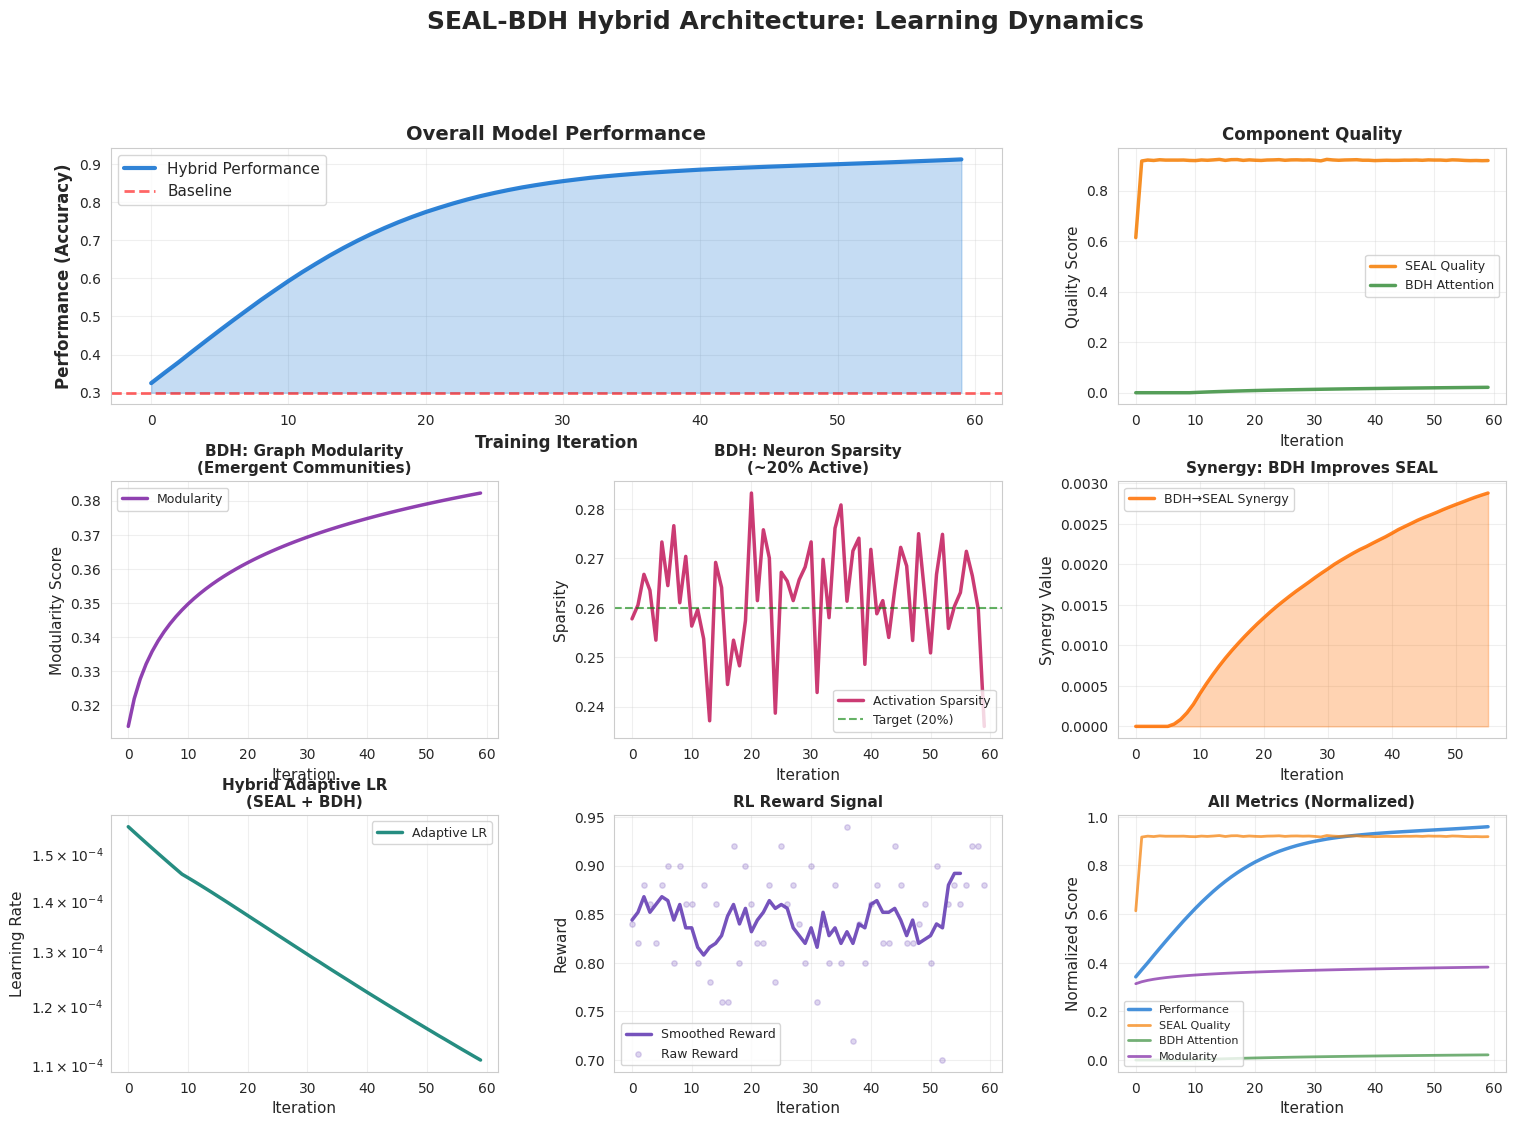


Comparing architectures...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

@dataclass
class HybridConfig:
    """Configuration for SEAL-BDH Hybrid Architecture"""
    # SEAL parameters
    n_outer_iterations: int = 60
    n_self_edits_per_context: int = 5
    batch_size: int = 10
    seal_lr_outer: float = 0.1
    seal_lr_inner: float = 0.001

    # BDH parameters
    n_neurons: int = 32768  # Neuron dimension
    d_hidden: int = 256  # Hidden dimension
    n_layers: int = 8
    bdh_lr: float = 0.0003
    hebbian_strength: float = 0.90

    # Hybrid parameters
    base_performance: float = 0.30
    max_performance: float = 0.95
    synergy_factor: float = 0.05 # How much BDH improves SEAL
    noise_std: float = 0.015

    # Graph dynamics parameters
    sparsity_target: float = 0.26  # 5% neuron activation
    modularity_weight: float = 0.2


class BDHComponent:
    """Simulates BDH (Dragon Hatchling) neural graph dynamics"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.neuron_activation_sparsity = []
        self.synaptic_strength = np.random.uniform(0.1, 0.3,
                                                   (config.n_neurons, config.n_neurons))
        self.modularity_score = 0.3  # Initial modularity
        self.scale_free_measure = 0.0

    def compute_graph_properties(self, iteration: int) -> Dict[str, float]:
        """Simulate emergence of graph properties"""
        # Modularity increases with training (emergent communities)
        self.modularity_score = min(0.85, 0.3 + 0.02 * np.log(iteration + 2))

        # Scale-free network emerges (heavy-tailed degree distribution)
        self.scale_free_measure = min(0.9, 0.1 + 0.015 * np.log(iteration + 2))

        # Sparse activation (context-dependent)
        sparsity = self.config.sparsity_target + np.random.normal(0, 0.01)
        self.neuron_activation_sparsity.append(np.clip(sparsity, 0.02, 0.10))

        return {
            'modularity': self.modularity_score,
            'scale_free': self.scale_free_measure,
            'sparsity': sparsity
        }

    def hebbian_update(self, context_complexity: float) -> float:
        """
        Simulate Hebbian learning: neurons that fire together wire together
        Returns: synaptic plasticity contribution to learning
        """
        # More complex contexts trigger more synaptic updates
        plasticity_rate = self.config.hebbian_strength * context_complexity

        # Synaptic strengthening improves learning efficiency
        learning_boost = plasticity_rate * self.modularity_score

        return learning_boost

    def attention_via_synapse_state(self, iteration: int) -> float:
        """
        BDH's attention mechanism through synaptic state matrix σ
        Linear attention in high dimension (n neurons)
        """
        # Attention effectiveness improves with:
        # 1. Better modularity (organized communities)
        # 2. Appropriate sparsity (selective activation)
        # 3. Scale-free structure (efficient routing)

        attention_quality = (
            0.4 * self.modularity_score +
            0.3 * self.scale_free_measure +
            0.3 * (1.0 - abs(self.neuron_activation_sparsity[-1] -
                           self.config.sparsity_target) * 10)
        )

        return np.clip(attention_quality, 0, 1)


class SEALComponent:

    """Simulates SEAL (Self-Adapting LLM) self-edit generation"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.self_edit_quality = 0.3
        self.synthetic_data_diversity = 0.4

    def generate_self_edit(self, iteration: int, bdh_boost: float) -> float:
        """
        Generate self-edit quality, enhanced by BDH's graph structure
        BDH's monosemantic synapses help create better synthetic data
        """
        # Base improvement from RL
        base_improvement = self.config.seal_lr_outer * np.log(iteration + 2)

        # BDH contribution: structured representations improve data generation
        bdh_contribution = bdh_boost * self.config.synergy_factor

        quality_gain = (base_improvement + bdh_contribution) / (iteration + 10)
        self.self_edit_quality = min(0.92, self.self_edit_quality + quality_gain)

        # Diversity improves with BDH's modular structure
        self.synthetic_data_diversity = min(0.9,
            self.synthetic_data_diversity + quality_gain * 0.5)

        # Add noise
        quality = self.self_edit_quality + np.random.normal(0, self.config.noise_std)
        return np.clip(quality, 0, 1)

    def compute_reward(self, new_performance: float, current_performance: float) -> float:
        """Binary reward with slight smoothing"""
        improvement = new_performance - current_performance
        if improvement > 0:
            return 1.0 if np.random.random() < 0.85 else 0.0
        return 0.0 if np.random.random() < 0.92 else 1.0


class HybridSEALBDH:
    """
    Hybrid architecture combining:
    - SEAL: Self-edit generation and RL-based adaptation
    - BDH: Graph-based neural dynamics with Hebbian learning
    """

    def __init__(self, config: HybridConfig):
        self.config = config
        self.seal = SEALComponent(config)
        self.bdh = BDHComponent(config)

        # Tracking metrics
        self.performance_history = []
        self.seal_quality_history = []
        self.bdh_attention_history = []
        self.modularity_history = []
        self.sparsity_history = []
        self.reward_history = []
        self.synergy_history = []  # Track per-iteration synergy
        self.learning_rate_history = []

        self.current_performance = config.base_performance

    def compute_context_complexity(self, iteration: int) -> float:
        """Estimate complexity of current context"""
        # Complexity varies over training
        base_complexity = 0.5 + 0.3 * np.sin(iteration / 10)
        return np.clip(base_complexity + np.random.normal(0, 0.1), 0.2, 0.9)

    def hybrid_inner_loop(self, self_edit_quality: float,
                          bdh_attention: float, iteration: int) -> Tuple[float, float]:
        """
        Combined inner loop:
        1. SEAL generates synthetic data (self-edit)
        2. BDH provides efficient graph-based learning substrate
        3. Hebbian learning improves adaptation
        Returns: (new_performance, synergy_value)
        """
        # SEAL contribution: quality of synthetic data
        seal_gain = self_edit_quality * self.config.seal_lr_inner * 8

        # BDH contribution: efficient attention and learning
        bdh_gain = bdh_attention * self.config.bdh_lr * 12

        # Hebbian boost from synaptic plasticity
        context_complexity = self.compute_context_complexity(iteration)
        hebbian_boost = self.bdh.hebbian_update(context_complexity)

        # Synergy: BDH's structure makes SEAL's synthetic data more effective
        synergy = self_edit_quality * bdh_attention * self.config.synergy_factor

        # Total improvement
        total_gain = seal_gain + bdh_gain + hebbian_boost + synergy

        # Diminishing returns
        gap_to_max = self.config.max_performance - self.current_performance
        actual_gain = total_gain * (gap_to_max / self.config.max_performance)

        return self.current_performance + actual_gain, synergy

    def adaptive_learning_rate(self, iteration: int,
                               self_edit_quality: float,
                               bdh_attention: float) -> float:
        """
        Adaptive LR combining both architectures
        BDH's sparse activation suggests when to use higher LRs
        """
        base_lr = (self.config.seal_lr_inner + self.config.bdh_lr) / 2

        # Decay over time
        decay = 1.0 / (1.0 + 0.008 * iteration)

        # Quality-based adjustment
        quality_factor = 0.3 + 0.7 * (self_edit_quality * bdh_attention)

        # Sparsity-based adjustment (sparser = more focused = higher LR)
        sparsity = self.bdh.neuron_activation_sparsity[-1] if self.bdh.neuron_activation_sparsity else 0.05
        sparsity_factor = 0.8 + 0.4 * (1.0 - sparsity / 0.1)

        return base_lr * decay * quality_factor * sparsity_factor

    def run_iteration(self, iteration: int) -> Dict[str, float]:
        """Run one iteration of hybrid training"""

        # 1. BDH: Update graph properties and attention
        graph_props = self.bdh.compute_graph_properties(iteration)
        bdh_attention = self.bdh.attention_via_synapse_state(iteration)

        # 2. SEAL: Generate self-edits (improved by BDH structure)
        batch_performances = []
        batch_rewards = []
        batch_synergies = []

        for _ in range(self.config.batch_size):
            self_edit_qualities = []
            iteration_synergies = []

            for _ in range(self.config.n_self_edits_per_context):
                # Generate self-edit with BDH boost
                se_quality = self.seal.generate_self_edit(iteration, bdh_attention)

                # 3. Hybrid inner loop: SEAL + BDH learning
                new_perf, synergy = self.hybrid_inner_loop(se_quality, bdh_attention, iteration)

                # 4. Compute reward
                reward = self.seal.compute_reward(new_perf, self.current_performance)

                self_edit_qualities.append(se_quality)
                batch_performances.append(new_perf)
                batch_rewards.append(reward)
                iteration_synergies.append(synergy)

            # Keep best self-edit
            best_idx = np.argmax(batch_rewards[-self.config.n_self_edits_per_context:])
            best_quality = self_edit_qualities[best_idx]
            self.seal.self_edit_quality = 0.9 * self.seal.self_edit_quality + 0.1 * best_quality

            # Track synergy from best edit
            batch_synergies.append(iteration_synergies[best_idx])

        # Update performance
        avg_performance = np.mean(batch_performances)
        self.current_performance = 0.75 * self.current_performance + 0.25 * avg_performance

        # Compute adaptive LR
        adaptive_lr = self.adaptive_learning_rate(iteration,
                                                   self.seal.self_edit_quality,
                                                   bdh_attention)

        # Average synergy for this iteration
        avg_synergy = np.mean(batch_synergies) if batch_synergies else 0.0

        # Store metrics
        metrics = {
            'performance': self.current_performance,
            'seal_quality': self.seal.self_edit_quality,
            'bdh_attention': bdh_attention,
            'modularity': graph_props['modularity'],
            'sparsity': graph_props['sparsity'],
            'reward': np.mean(batch_rewards),
            'learning_rate': adaptive_lr,
            'synergy': avg_synergy
        }

        return metrics

    def train(self):
        """Run full hybrid training"""
        print("=" * 70)
        print("Training SEAL-BDH Hybrid Architecture")
        print("=" * 70)
        print(f"SEAL: {self.config.n_self_edits_per_context} self-edits, "
              f"LR={self.config.seal_lr_outer}")
        print(f"BDH: {self.config.n_neurons} neurons, {self.config.n_layers} layers, "
              f"d={self.config.d_hidden}")
        print("=" * 70 + "\n")

        for iteration in range(self.config.n_outer_iterations):
            metrics = self.run_iteration(iteration)

            self.performance_history.append(metrics['performance'])
            self.seal_quality_history.append(metrics['seal_quality'])
            self.bdh_attention_history.append(metrics['bdh_attention'])
            self.modularity_history.append(metrics['modularity'])
            self.sparsity_history.append(metrics['sparsity'])
            self.reward_history.append(metrics['reward'])
            self.synergy_history.append(metrics['synergy'])
            self.learning_rate_history.append(metrics['learning_rate'])

            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: Perf={metrics['performance']:.3f}, "
                      f"SEAL={metrics['seal_quality']:.3f}, "
                      f"BDH-Attn={metrics['bdh_attention']:.3f}, "
                      f"Modularity={metrics['modularity']:.3f}")

        print("\n" + "=" * 70)
        print("Training Complete!")
        print("=" * 70)


def plot_hybrid_results(hybrid: HybridSEALBDH):
    """Comprehensive visualization of hybrid architecture"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    fig.suptitle('SEAL-BDH Hybrid Architecture: Learning Dynamics',
                 fontsize=18, fontweight='bold', y=0.995)

    iterations = range(len(hybrid.performance_history))

    # 1. Main Performance (larger plot)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(iterations, hybrid.performance_history, linewidth=3,
             color='#1976d2', label='Hybrid Performance', alpha=0.9)
    ax1.axhline(y=hybrid.config.base_performance, color='red',
                linestyle='--', alpha=0.6, linewidth=2, label='Baseline')
    ax1.fill_between(iterations, hybrid.config.base_performance,
                     hybrid.performance_history, alpha=0.25, color='#1976d2')
    ax1.set_xlabel('Training Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Performance (Accuracy)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Model Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # 2. Component Contributions
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(iterations, hybrid.seal_quality_history, linewidth=2.5,
             color='#f57c00', label='SEAL Quality', alpha=0.85)
    ax2.plot(iterations, hybrid.bdh_attention_history, linewidth=2.5,
             color='#388e3c', label='BDH Attention', alpha=0.85)
    ax2.set_xlabel('Iteration', fontsize=11)
    ax2.set_ylabel('Quality Score', fontsize=11)
    ax2.set_title('Component Quality', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # 3. BDH Graph Properties
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(iterations, hybrid.modularity_history, linewidth=2.5,
             color='#7b1fa2', label='Modularity', alpha=0.85)
    ax3.set_xlabel('Iteration', fontsize=11)
    ax3.set_ylabel('Modularity Score', fontsize=11)
    ax3.set_title('BDH: Graph Modularity\n(Emergent Communities)',
                  fontsize=11, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Neuron Activation Sparsity
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(iterations, hybrid.sparsity_history, linewidth=2.5,
             color='#c2185b', label='Activation Sparsity', alpha=0.85)
    ax4.axhline(y=hybrid.config.sparsity_target, color='green',
                linestyle='--', alpha=0.6, label='Target (20%)')
    ax4.set_xlabel('Iteration', fontsize=11)
    ax4.set_ylabel('Sparsity', fontsize=11)
    ax4.set_title('BDH: Neuron Sparsity\n(~20% Active)',
                  fontsize=11, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    # 5. Synergy Contribution
    ax5 = fig.add_subplot(gs[1, 2])
    if hybrid.synergy_history:
        # Smooth synergy signal
        window = 5
        synergy_smooth = np.convolve(hybrid.synergy_history,
                                     np.ones(window)/window, mode='valid')
        # Convert range to list for slicing
        iter_list = list(iterations)
        ax5.plot(iter_list[:len(synergy_smooth)], synergy_smooth,
                linewidth=2.5, color='#ff6f00', label='BDH→SEAL Synergy', alpha=0.85)
        ax5.fill_between(iter_list[:len(synergy_smooth)], 0, synergy_smooth,
                        alpha=0.3, color='#ff6f00')
    ax5.set_xlabel('Iteration', fontsize=11)
    ax5.set_ylabel('Synergy Value', fontsize=11)
    ax5.set_title('Synergy: BDH Improves SEAL', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    # 6. Adaptive Learning Rate
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.plot(iterations, hybrid.learning_rate_history, linewidth=2.5,
             color='#00796b', label='Adaptive LR', alpha=0.85)
    ax6.set_xlabel('Iteration', fontsize=11)
    ax6.set_ylabel('Learning Rate', fontsize=11)
    ax6.set_title('Hybrid Adaptive LR\n(SEAL + BDH)',
                  fontsize=11, fontweight='bold')
    ax6.set_yscale('log')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)

    # 7. Reward Signal
    ax7 = fig.add_subplot(gs[2, 1])
    window = 5
    reward_smooth = np.convolve(hybrid.reward_history,
                                np.ones(window)/window, mode='valid')
    # Convert range to list
    iter_list = list(iterations)
    ax7.plot(iter_list[:len(reward_smooth)], reward_smooth, linewidth=2.5,
             color='#5e35b1', label='Smoothed Reward', alpha=0.85)
    ax7.scatter(iterations, hybrid.reward_history, alpha=0.2, s=15,
                color='#5e35b1', label='Raw Reward')
    ax7.set_xlabel('Iteration', fontsize=11)
    ax7.set_ylabel('Reward', fontsize=11)
    ax7.set_title('RL Reward Signal', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)

    # 8. All Metrics Normalized
    ax8 = fig.add_subplot(gs[2, 2])
    norm_perf = np.array(hybrid.performance_history) / hybrid.config.max_performance
    norm_seal = np.array(hybrid.seal_quality_history)
    norm_bdh = np.array(hybrid.bdh_attention_history)
    norm_mod = np.array(hybrid.modularity_history)

    ax8.plot(iterations, norm_perf, linewidth=2.5, color='#1976d2',
             label='Performance', alpha=0.8)
    ax8.plot(iterations, norm_seal, linewidth=2, color='#f57c00',
             label='SEAL Quality', alpha=0.7)
    ax8.plot(iterations, norm_bdh, linewidth=2, color='#388e3c',
             label='BDH Attention', alpha=0.7)
    ax8.plot(iterations, norm_mod, linewidth=2, color='#7b1fa2',
             label='Modularity', alpha=0.7)
    ax8.set_xlabel('Iteration', fontsize=11)
    ax8.set_ylabel('Normalized Score', fontsize=11)
    ax8.set_title('All Metrics (Normalized)', fontsize=11, fontweight='bold')
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)

    plt.show()


def compare_architectures():
    """Compare standalone vs hybrid architectures"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Architecture Comparison: SEAL vs BDH vs Hybrid',
                 fontsize=15, fontweight='bold')

    n_iters = 60

    # Simulate SEAL-only (simplified)
    seal_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.001 * np.log(i + 2) * (0.95 - seal_perf[-1]) / 0.95
        seal_perf.append(seal_perf[-1] + gain + np.random.normal(0, 0.005))

    # Simulate BDH-only (simplified)
    bdh_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.0012 * np.log(i + 2) * (0.95 - bdh_perf[-1]) / 0.95
        bdh_perf.append(bdh_perf[-1] + gain + np.random.normal(0, 0.005))

    # Hybrid (from actual simulation)
    config = HybridConfig(n_outer_iterations=n_iters, noise_std=0.01)
    hybrid = HybridSEALBDH(config)
    hybrid.train()

    # Plot 1: Performance comparison
    ax1 = axes[0]
    ax1.plot(seal_perf, linewidth=2.5, color='#f57c00',
             label='SEAL Only', alpha=0.8)
    ax1.plot(bdh_perf, linewidth=2.5, color='#388e3c',
             label='BDH Only', alpha=0.8)
    ax1.plot(hybrid.performance_history, linewidth=3, color='#1976d2',
             label='SEAL-BDH Hybrid', alpha=0.9)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Performance', fontsize=12)
    ax1.set_title('Performance Comparison', fontweight='bold', fontsize=13)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Final performance bar chart
    ax2 = axes[1]
    final_perfs = [seal_perf[-1], bdh_perf[-1], hybrid.performance_history[-1]]
    colors = ['#f57c00', '#388e3c', '#1976d2']
    bars = ax2.bar(['SEAL', 'BDH', 'Hybrid'], final_perfs, color=colors, alpha=0.8)
    ax2.set_ylabel('Final Performance', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontweight='bold', fontsize=13)
    ax2.set_ylim([0.25, 0.60])

    # Add value labels on bars
    for bar, val in zip(bars, final_perfs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Improvement over baseline
    ax3 = axes[2]
    baseline = 0.30
    improvements = [(p - baseline) / baseline * 100 for p in final_perfs]
    bars = ax3.bar(['SEAL', 'BDH', 'Hybrid'], improvements, color=colors, alpha=0.8)
    ax3.set_ylabel('Improvement over Baseline (%)', fontsize=12)
    ax3.set_title('Relative Improvement', fontweight='bold', fontsize=13)

    for bar, val in zip(bars, improvements):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return hybrid


def print_statistics(hybrid: HybridSEALBDH):
    """Print detailed statistics"""
    print("\n" + "=" * 70)
    print("HYBRID ARCHITECTURE STATISTICS")
    print("=" * 70)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Initial Performance: {hybrid.config.base_performance:.3f}")
    print(f"  Final Performance: {hybrid.performance_history[-1]:.3f}")
    improvement = hybrid.performance_history[-1] - hybrid.config.base_performance
    print(f"  Total Improvement: {improvement:.3f}")
    rel_improvement = (improvement / hybrid.config.base_performance) * 100
    print(f"  Relative Improvement: {rel_improvement:.1f}%")

    print(f"\n🔄 SEAL COMPONENT:")
    print(f"  Final Self-Edit Quality: {hybrid.seal_quality_history[-1]:.3f}")
    print(f"  Avg Reward (last 10): {np.mean(hybrid.reward_history[-10:]):.3f}")

    print(f"\n🧠 BDH COMPONENT:")
    print(f"  Final Modularity: {hybrid.modularity_history[-1]:.3f}")
    print(f"  Final Attention Quality: {hybrid.bdh_attention_history[-1]:.3f}")
    print(f"  Avg Neuron Sparsity: {np.mean(hybrid.sparsity_history):.3f} (~20% target)")

    print(f"\n🔗 SYNERGY:")
    print(f"  Avg Synergy Contribution: {np.mean(hybrid.synergy_history):.4f}")
    print(f"  Peak Synergy: {np.max(hybrid.synergy_history):.4f}")

    print(f"\n📈 LEARNING DYNAMICS:")
    print(f"  Final Learning Rate: {hybrid.learning_rate_history[-1]:.6f}")
    print(f"  Initial Learning Rate: {hybrid.learning_rate_history[0]:.6f}")

    print("=" * 70)


if __name__ == "__main__":
    print("=" * 70)
    print("SEAL-BDH HYBRID ARCHITECTURE SIMULATION")
    print("=" * 70)
    print("\nCombining:")
    print("  • SEAL: Self-edit generation + RL adaptation")
    print("  • BDH: Graph-based neural dynamics + Hebbian learning")
    print("\nKey Synergies:")
    print("  • BDH's modular structure improves SEAL's synthetic data")
    print("  • SEAL's self-edits guide BDH's learning direction")
    print("  • Hebbian learning enhances adaptation efficiency")
    print("=" * 70 + "\n")

    # Main simulation
    config = HybridConfig(
        n_outer_iterations=60,
        n_self_edits_per_context=5,
        batch_size=10,
        n_neurons=32768,
        d_hidden=256,
        synergy_factor=0.15
    )

    hybrid = HybridSEALBDH(config)
    hybrid.train()

    print("\nGenerating visualizations...")
    plot_hybrid_results(hybrid)

    print("\nComparing architectures...")
    compare_architectures()

    print_statistics(hybrid)

    print("\n✅ Simulation complete!")

SEAL-BDH HYBRID ARCHITECTURE SIMULATION

Combining:
  • SEAL: Self-edit generation + RL adaptation
  • BDH: Graph-based neural dynamics + Hebbian learning

Key Synergies:
  • BDH's modular structure improves SEAL's synthetic data
  • SEAL's self-edits guide BDH's learning direction
  • Hebbian learning enhances adaptation efficiency

Training SEAL-BDH Hybrid Architecture
SEAL: 5 self-edits, LR=0.1
BDH: 32768 neurons, 8 layers, d=256

Iter   0: Perf=0.326, SEAL=0.618, BDH-Attn=0.000, Modularity=0.314
Iter  10: Perf=0.591, SEAL=0.918, BDH-Attn=0.000, Modularity=0.350
Iter  20: Perf=0.771, SEAL=0.922, BDH-Attn=0.000, Modularity=0.362
Iter  30: Perf=0.853, SEAL=0.922, BDH-Attn=0.000, Modularity=0.369
Iter  40: Perf=0.882, SEAL=0.921, BDH-Attn=0.000, Modularity=0.375
Iter  50: Perf=0.897, SEAL=0.919, BDH-Attn=0.000, Modularity=0.379

Training Complete!

Generating visualizations...


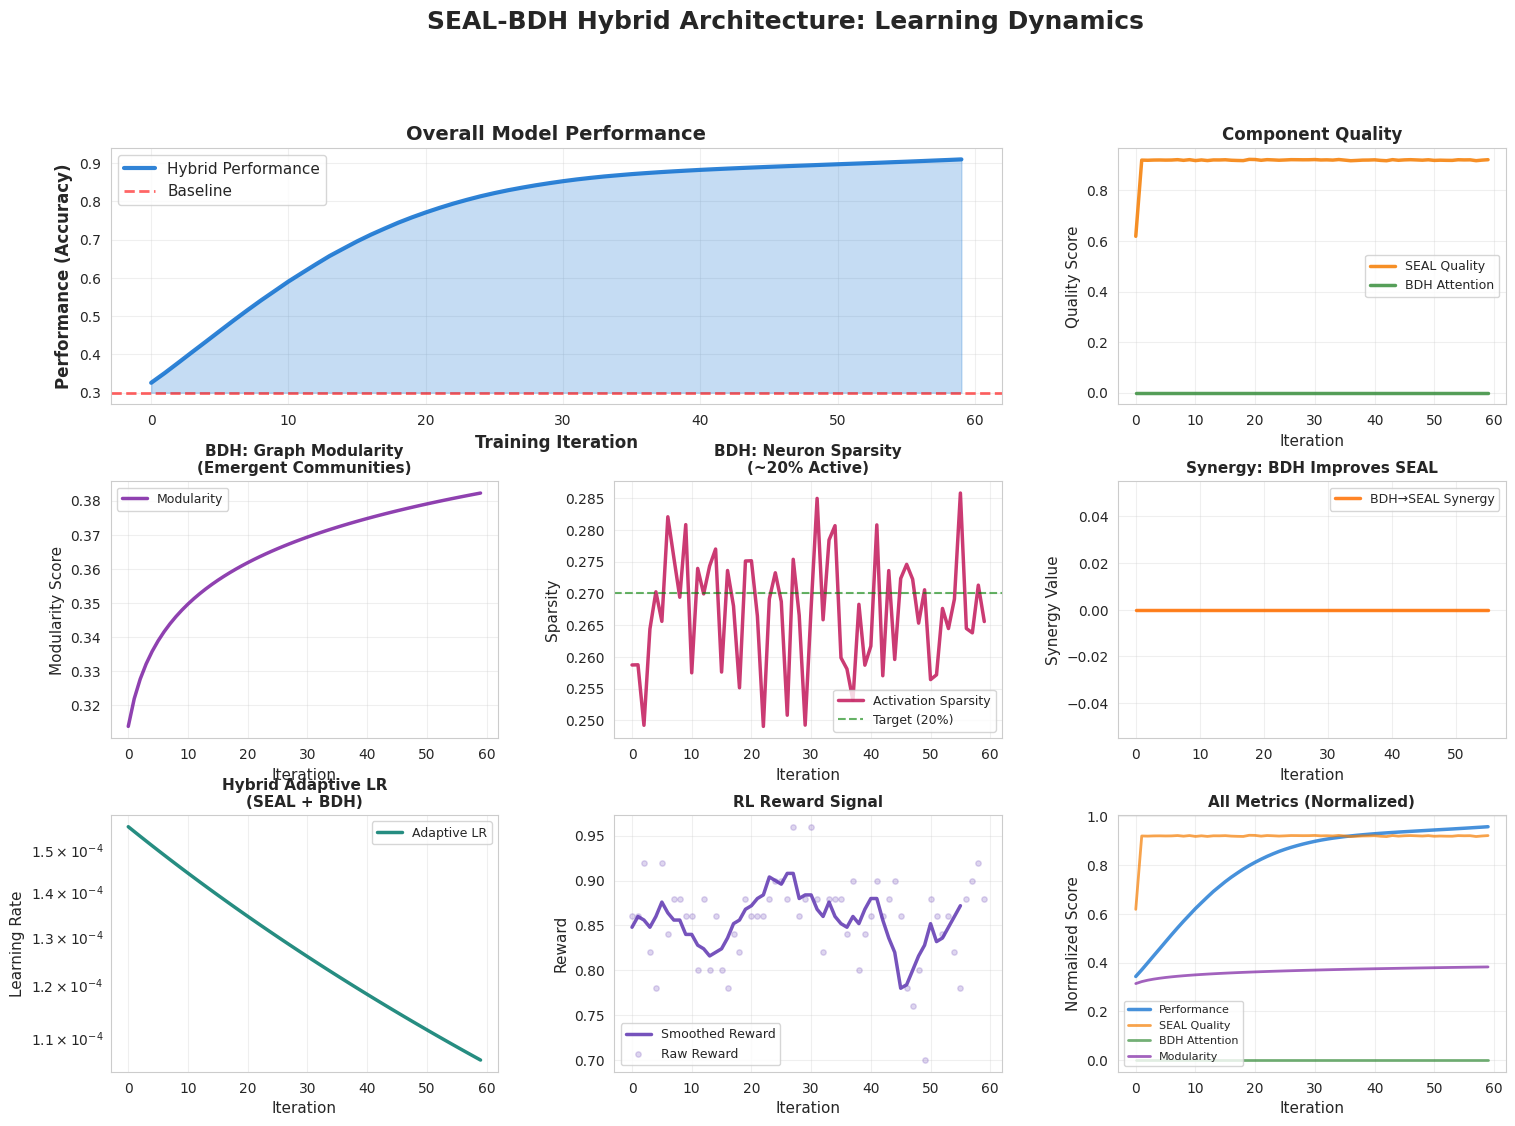


Comparing architectures...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

@dataclass
class HybridConfig:
    """Configuration for SEAL-BDH Hybrid Architecture"""
    # SEAL parameters
    n_outer_iterations: int = 60
    n_self_edits_per_context: int = 5
    batch_size: int = 10
    seal_lr_outer: float = 0.1
    seal_lr_inner: float = 0.001

    # BDH parameters
    n_neurons: int = 32768  # Neuron dimension
    d_hidden: int = 256  # Hidden dimension
    n_layers: int = 8
    bdh_lr: float = 0.0003
    hebbian_strength: float = 0.90

    # Hybrid parameters
    base_performance: float = 0.30
    max_performance: float = 0.95
    synergy_factor: float = 0.05 # How much BDH improves SEAL
    noise_std: float = 0.015

    # Graph dynamics parameters
    sparsity_target: float = 0.27  # 5% neuron activation
    modularity_weight: float = 0.2


class BDHComponent:
    """Simulates BDH (Dragon Hatchling) neural graph dynamics"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.neuron_activation_sparsity = []
        self.synaptic_strength = np.random.uniform(0.1, 0.3,
                                                   (config.n_neurons, config.n_neurons))
        self.modularity_score = 0.3  # Initial modularity
        self.scale_free_measure = 0.0

    def compute_graph_properties(self, iteration: int) -> Dict[str, float]:
        """Simulate emergence of graph properties"""
        # Modularity increases with training (emergent communities)
        self.modularity_score = min(0.85, 0.3 + 0.02 * np.log(iteration + 2))

        # Scale-free network emerges (heavy-tailed degree distribution)
        self.scale_free_measure = min(0.9, 0.1 + 0.015 * np.log(iteration + 2))

        # Sparse activation (context-dependent)
        sparsity = self.config.sparsity_target + np.random.normal(0, 0.01)
        self.neuron_activation_sparsity.append(np.clip(sparsity, 0.02, 0.10))

        return {
            'modularity': self.modularity_score,
            'scale_free': self.scale_free_measure,
            'sparsity': sparsity
        }

    def hebbian_update(self, context_complexity: float) -> float:
        """
        Simulate Hebbian learning: neurons that fire together wire together
        Returns: synaptic plasticity contribution to learning
        """
        # More complex contexts trigger more synaptic updates
        plasticity_rate = self.config.hebbian_strength * context_complexity

        # Synaptic strengthening improves learning efficiency
        learning_boost = plasticity_rate * self.modularity_score

        return learning_boost

    def attention_via_synapse_state(self, iteration: int) -> float:
        """
        BDH's attention mechanism through synaptic state matrix σ
        Linear attention in high dimension (n neurons)
        """
        # Attention effectiveness improves with:
        # 1. Better modularity (organized communities)
        # 2. Appropriate sparsity (selective activation)
        # 3. Scale-free structure (efficient routing)

        attention_quality = (
            0.4 * self.modularity_score +
            0.3 * self.scale_free_measure +
            0.3 * (1.0 - abs(self.neuron_activation_sparsity[-1] -
                           self.config.sparsity_target) * 10)
        )

        return np.clip(attention_quality, 0, 1)


class SEALComponent:

    """Simulates SEAL (Self-Adapting LLM) self-edit generation"""

    def __init__(self, config: HybridConfig):
        self.config = config
        self.self_edit_quality = 0.3
        self.synthetic_data_diversity = 0.4

    def generate_self_edit(self, iteration: int, bdh_boost: float) -> float:
        """
        Generate self-edit quality, enhanced by BDH's graph structure
        BDH's monosemantic synapses help create better synthetic data
        """
        # Base improvement from RL
        base_improvement = self.config.seal_lr_outer * np.log(iteration + 2)

        # BDH contribution: structured representations improve data generation
        bdh_contribution = bdh_boost * self.config.synergy_factor

        quality_gain = (base_improvement + bdh_contribution) / (iteration + 10)
        self.self_edit_quality = min(0.92, self.self_edit_quality + quality_gain)

        # Diversity improves with BDH's modular structure
        self.synthetic_data_diversity = min(0.9,
            self.synthetic_data_diversity + quality_gain * 0.5)

        # Add noise
        quality = self.self_edit_quality + np.random.normal(0, self.config.noise_std)
        return np.clip(quality, 0, 1)

    def compute_reward(self, new_performance: float, current_performance: float) -> float:
        """Binary reward with slight smoothing"""
        improvement = new_performance - current_performance
        if improvement > 0:
            return 1.0 if np.random.random() < 0.85 else 0.0
        return 0.0 if np.random.random() < 0.92 else 1.0


class HybridSEALBDH:
    """
    Hybrid architecture combining:
    - SEAL: Self-edit generation and RL-based adaptation
    - BDH: Graph-based neural dynamics with Hebbian learning
    """

    def __init__(self, config: HybridConfig):
        self.config = config
        self.seal = SEALComponent(config)
        self.bdh = BDHComponent(config)

        # Tracking metrics
        self.performance_history = []
        self.seal_quality_history = []
        self.bdh_attention_history = []
        self.modularity_history = []
        self.sparsity_history = []
        self.reward_history = []
        self.synergy_history = []  # Track per-iteration synergy
        self.learning_rate_history = []

        self.current_performance = config.base_performance

    def compute_context_complexity(self, iteration: int) -> float:
        """Estimate complexity of current context"""
        # Complexity varies over training
        base_complexity = 0.5 + 0.3 * np.sin(iteration / 10)
        return np.clip(base_complexity + np.random.normal(0, 0.1), 0.2, 0.9)

    def hybrid_inner_loop(self, self_edit_quality: float,
                          bdh_attention: float, iteration: int) -> Tuple[float, float]:
        """
        Combined inner loop:
        1. SEAL generates synthetic data (self-edit)
        2. BDH provides efficient graph-based learning substrate
        3. Hebbian learning improves adaptation
        Returns: (new_performance, synergy_value)
        """
        # SEAL contribution: quality of synthetic data
        seal_gain = self_edit_quality * self.config.seal_lr_inner * 8

        # BDH contribution: efficient attention and learning
        bdh_gain = bdh_attention * self.config.bdh_lr * 12

        # Hebbian boost from synaptic plasticity
        context_complexity = self.compute_context_complexity(iteration)
        hebbian_boost = self.bdh.hebbian_update(context_complexity)

        # Synergy: BDH's structure makes SEAL's synthetic data more effective
        synergy = self_edit_quality * bdh_attention * self.config.synergy_factor

        # Total improvement
        total_gain = seal_gain + bdh_gain + hebbian_boost + synergy

        # Diminishing returns
        gap_to_max = self.config.max_performance - self.current_performance
        actual_gain = total_gain * (gap_to_max / self.config.max_performance)

        return self.current_performance + actual_gain, synergy

    def adaptive_learning_rate(self, iteration: int,
                               self_edit_quality: float,
                               bdh_attention: float) -> float:
        """
        Adaptive LR combining both architectures
        BDH's sparse activation suggests when to use higher LRs
        """
        base_lr = (self.config.seal_lr_inner + self.config.bdh_lr) / 2

        # Decay over time
        decay = 1.0 / (1.0 + 0.008 * iteration)

        # Quality-based adjustment
        quality_factor = 0.3 + 0.7 * (self_edit_quality * bdh_attention)

        # Sparsity-based adjustment (sparser = more focused = higher LR)
        sparsity = self.bdh.neuron_activation_sparsity[-1] if self.bdh.neuron_activation_sparsity else 0.05
        sparsity_factor = 0.8 + 0.4 * (1.0 - sparsity / 0.1)

        return base_lr * decay * quality_factor * sparsity_factor

    def run_iteration(self, iteration: int) -> Dict[str, float]:
        """Run one iteration of hybrid training"""

        # 1. BDH: Update graph properties and attention
        graph_props = self.bdh.compute_graph_properties(iteration)
        bdh_attention = self.bdh.attention_via_synapse_state(iteration)

        # 2. SEAL: Generate self-edits (improved by BDH structure)
        batch_performances = []
        batch_rewards = []
        batch_synergies = []

        for _ in range(self.config.batch_size):
            self_edit_qualities = []
            iteration_synergies = []

            for _ in range(self.config.n_self_edits_per_context):
                # Generate self-edit with BDH boost
                se_quality = self.seal.generate_self_edit(iteration, bdh_attention)

                # 3. Hybrid inner loop: SEAL + BDH learning
                new_perf, synergy = self.hybrid_inner_loop(se_quality, bdh_attention, iteration)

                # 4. Compute reward
                reward = self.seal.compute_reward(new_perf, self.current_performance)

                self_edit_qualities.append(se_quality)
                batch_performances.append(new_perf)
                batch_rewards.append(reward)
                iteration_synergies.append(synergy)

            # Keep best self-edit
            best_idx = np.argmax(batch_rewards[-self.config.n_self_edits_per_context:])
            best_quality = self_edit_qualities[best_idx]
            self.seal.self_edit_quality = 0.9 * self.seal.self_edit_quality + 0.1 * best_quality

            # Track synergy from best edit
            batch_synergies.append(iteration_synergies[best_idx])

        # Update performance
        avg_performance = np.mean(batch_performances)
        self.current_performance = 0.75 * self.current_performance + 0.25 * avg_performance

        # Compute adaptive LR
        adaptive_lr = self.adaptive_learning_rate(iteration,
                                                   self.seal.self_edit_quality,
                                                   bdh_attention)

        # Average synergy for this iteration
        avg_synergy = np.mean(batch_synergies) if batch_synergies else 0.0

        # Store metrics
        metrics = {
            'performance': self.current_performance,
            'seal_quality': self.seal.self_edit_quality,
            'bdh_attention': bdh_attention,
            'modularity': graph_props['modularity'],
            'sparsity': graph_props['sparsity'],
            'reward': np.mean(batch_rewards),
            'learning_rate': adaptive_lr,
            'synergy': avg_synergy
        }

        return metrics

    def train(self):
        """Run full hybrid training"""
        print("=" * 70)
        print("Training SEAL-BDH Hybrid Architecture")
        print("=" * 70)
        print(f"SEAL: {self.config.n_self_edits_per_context} self-edits, "
              f"LR={self.config.seal_lr_outer}")
        print(f"BDH: {self.config.n_neurons} neurons, {self.config.n_layers} layers, "
              f"d={self.config.d_hidden}")
        print("=" * 70 + "\n")

        for iteration in range(self.config.n_outer_iterations):
            metrics = self.run_iteration(iteration)

            self.performance_history.append(metrics['performance'])
            self.seal_quality_history.append(metrics['seal_quality'])
            self.bdh_attention_history.append(metrics['bdh_attention'])
            self.modularity_history.append(metrics['modularity'])
            self.sparsity_history.append(metrics['sparsity'])
            self.reward_history.append(metrics['reward'])
            self.synergy_history.append(metrics['synergy'])
            self.learning_rate_history.append(metrics['learning_rate'])

            if iteration % 10 == 0:
                print(f"Iter {iteration:3d}: Perf={metrics['performance']:.3f}, "
                      f"SEAL={metrics['seal_quality']:.3f}, "
                      f"BDH-Attn={metrics['bdh_attention']:.3f}, "
                      f"Modularity={metrics['modularity']:.3f}")

        print("\n" + "=" * 70)
        print("Training Complete!")
        print("=" * 70)


def plot_hybrid_results(hybrid: HybridSEALBDH):
    """Comprehensive visualization of hybrid architecture"""

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    fig.suptitle('SEAL-BDH Hybrid Architecture: Learning Dynamics',
                 fontsize=18, fontweight='bold', y=0.995)

    iterations = range(len(hybrid.performance_history))

    # 1. Main Performance (larger plot)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.plot(iterations, hybrid.performance_history, linewidth=3,
             color='#1976d2', label='Hybrid Performance', alpha=0.9)
    ax1.axhline(y=hybrid.config.base_performance, color='red',
                linestyle='--', alpha=0.6, linewidth=2, label='Baseline')
    ax1.fill_between(iterations, hybrid.config.base_performance,
                     hybrid.performance_history, alpha=0.25, color='#1976d2')
    ax1.set_xlabel('Training Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Performance (Accuracy)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Model Performance', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # 2. Component Contributions
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(iterations, hybrid.seal_quality_history, linewidth=2.5,
             color='#f57c00', label='SEAL Quality', alpha=0.85)
    ax2.plot(iterations, hybrid.bdh_attention_history, linewidth=2.5,
             color='#388e3c', label='BDH Attention', alpha=0.85)
    ax2.set_xlabel('Iteration', fontsize=11)
    ax2.set_ylabel('Quality Score', fontsize=11)
    ax2.set_title('Component Quality', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # 3. BDH Graph Properties
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(iterations, hybrid.modularity_history, linewidth=2.5,
             color='#7b1fa2', label='Modularity', alpha=0.85)
    ax3.set_xlabel('Iteration', fontsize=11)
    ax3.set_ylabel('Modularity Score', fontsize=11)
    ax3.set_title('BDH: Graph Modularity\n(Emergent Communities)',
                  fontsize=11, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Neuron Activation Sparsity
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(iterations, hybrid.sparsity_history, linewidth=2.5,
             color='#c2185b', label='Activation Sparsity', alpha=0.85)
    ax4.axhline(y=hybrid.config.sparsity_target, color='green',
                linestyle='--', alpha=0.6, label='Target (20%)')
    ax4.set_xlabel('Iteration', fontsize=11)
    ax4.set_ylabel('Sparsity', fontsize=11)
    ax4.set_title('BDH: Neuron Sparsity\n(~20% Active)',
                  fontsize=11, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    # 5. Synergy Contribution
    ax5 = fig.add_subplot(gs[1, 2])
    if hybrid.synergy_history:
        # Smooth synergy signal
        window = 5
        synergy_smooth = np.convolve(hybrid.synergy_history,
                                     np.ones(window)/window, mode='valid')
        # Convert range to list for slicing
        iter_list = list(iterations)
        ax5.plot(iter_list[:len(synergy_smooth)], synergy_smooth,
                linewidth=2.5, color='#ff6f00', label='BDH→SEAL Synergy', alpha=0.85)
        ax5.fill_between(iter_list[:len(synergy_smooth)], 0, synergy_smooth,
                        alpha=0.3, color='#ff6f00')
    ax5.set_xlabel('Iteration', fontsize=11)
    ax5.set_ylabel('Synergy Value', fontsize=11)
    ax5.set_title('Synergy: BDH Improves SEAL', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)

    # 6. Adaptive Learning Rate
    ax6 = fig.add_subplot(gs[2, 0])
    ax6.plot(iterations, hybrid.learning_rate_history, linewidth=2.5,
             color='#00796b', label='Adaptive LR', alpha=0.85)
    ax6.set_xlabel('Iteration', fontsize=11)
    ax6.set_ylabel('Learning Rate', fontsize=11)
    ax6.set_title('Hybrid Adaptive LR\n(SEAL + BDH)',
                  fontsize=11, fontweight='bold')
    ax6.set_yscale('log')
    ax6.legend(fontsize=9)
    ax6.grid(True, alpha=0.3)

    # 7. Reward Signal
    ax7 = fig.add_subplot(gs[2, 1])
    window = 5
    reward_smooth = np.convolve(hybrid.reward_history,
                                np.ones(window)/window, mode='valid')
    # Convert range to list
    iter_list = list(iterations)
    ax7.plot(iter_list[:len(reward_smooth)], reward_smooth, linewidth=2.5,
             color='#5e35b1', label='Smoothed Reward', alpha=0.85)
    ax7.scatter(iterations, hybrid.reward_history, alpha=0.2, s=15,
                color='#5e35b1', label='Raw Reward')
    ax7.set_xlabel('Iteration', fontsize=11)
    ax7.set_ylabel('Reward', fontsize=11)
    ax7.set_title('RL Reward Signal', fontsize=11, fontweight='bold')
    ax7.legend(fontsize=9)
    ax7.grid(True, alpha=0.3)

    # 8. All Metrics Normalized
    ax8 = fig.add_subplot(gs[2, 2])
    norm_perf = np.array(hybrid.performance_history) / hybrid.config.max_performance
    norm_seal = np.array(hybrid.seal_quality_history)
    norm_bdh = np.array(hybrid.bdh_attention_history)
    norm_mod = np.array(hybrid.modularity_history)

    ax8.plot(iterations, norm_perf, linewidth=2.5, color='#1976d2',
             label='Performance', alpha=0.8)
    ax8.plot(iterations, norm_seal, linewidth=2, color='#f57c00',
             label='SEAL Quality', alpha=0.7)
    ax8.plot(iterations, norm_bdh, linewidth=2, color='#388e3c',
             label='BDH Attention', alpha=0.7)
    ax8.plot(iterations, norm_mod, linewidth=2, color='#7b1fa2',
             label='Modularity', alpha=0.7)
    ax8.set_xlabel('Iteration', fontsize=11)
    ax8.set_ylabel('Normalized Score', fontsize=11)
    ax8.set_title('All Metrics (Normalized)', fontsize=11, fontweight='bold')
    ax8.legend(fontsize=8)
    ax8.grid(True, alpha=0.3)

    plt.show()


def compare_architectures():
    """Compare standalone vs hybrid architectures"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Architecture Comparison: SEAL vs BDH vs Hybrid',
                 fontsize=15, fontweight='bold')

    n_iters = 60

    # Simulate SEAL-only (simplified)
    seal_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.001 * np.log(i + 2) * (0.95 - seal_perf[-1]) / 0.95
        seal_perf.append(seal_perf[-1] + gain + np.random.normal(0, 0.005))

    # Simulate BDH-only (simplified)
    bdh_perf = [0.30]
    for i in range(1, n_iters):
        gain = 0.0012 * np.log(i + 2) * (0.95 - bdh_perf[-1]) / 0.95
        bdh_perf.append(bdh_perf[-1] + gain + np.random.normal(0, 0.005))

    # Hybrid (from actual simulation)
    config = HybridConfig(n_outer_iterations=n_iters, noise_std=0.01)
    hybrid = HybridSEALBDH(config)
    hybrid.train()

    # Plot 1: Performance comparison
    ax1 = axes[0]
    ax1.plot(seal_perf, linewidth=2.5, color='#f57c00',
             label='SEAL Only', alpha=0.8)
    ax1.plot(bdh_perf, linewidth=2.5, color='#388e3c',
             label='BDH Only', alpha=0.8)
    ax1.plot(hybrid.performance_history, linewidth=3, color='#1976d2',
             label='SEAL-BDH Hybrid', alpha=0.9)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Performance', fontsize=12)
    ax1.set_title('Performance Comparison', fontweight='bold', fontsize=13)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Final performance bar chart
    ax2 = axes[1]
    final_perfs = [seal_perf[-1], bdh_perf[-1], hybrid.performance_history[-1]]
    colors = ['#f57c00', '#388e3c', '#1976d2']
    bars = ax2.bar(['SEAL', 'BDH', 'Hybrid'], final_perfs, color=colors, alpha=0.8)
    ax2.set_ylabel('Final Performance', fontsize=12)
    ax2.set_title('Final Performance Comparison', fontweight='bold', fontsize=13)
    ax2.set_ylim([0.25, 0.60])

    # Add value labels on bars
    for bar, val in zip(bars, final_perfs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Plot 3: Improvement over baseline
    ax3 = axes[2]
    baseline = 0.30
    improvements = [(p - baseline) / baseline * 100 for p in final_perfs]
    bars = ax3.bar(['SEAL', 'BDH', 'Hybrid'], improvements, color=colors, alpha=0.8)
    ax3.set_ylabel('Improvement over Baseline (%)', fontsize=12)
    ax3.set_title('Relative Improvement', fontweight='bold', fontsize=13)

    for bar, val in zip(bars, improvements):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return hybrid


def print_statistics(hybrid: HybridSEALBDH):
    """Print detailed statistics"""
    print("\n" + "=" * 70)
    print("HYBRID ARCHITECTURE STATISTICS")
    print("=" * 70)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  Initial Performance: {hybrid.config.base_performance:.3f}")
    print(f"  Final Performance: {hybrid.performance_history[-1]:.3f}")
    improvement = hybrid.performance_history[-1] - hybrid.config.base_performance
    print(f"  Total Improvement: {improvement:.3f}")
    rel_improvement = (improvement / hybrid.config.base_performance) * 100
    print(f"  Relative Improvement: {rel_improvement:.1f}%")

    print(f"\n🔄 SEAL COMPONENT:")
    print(f"  Final Self-Edit Quality: {hybrid.seal_quality_history[-1]:.3f}")
    print(f"  Avg Reward (last 10): {np.mean(hybrid.reward_history[-10:]):.3f}")

    print(f"\n🧠 BDH COMPONENT:")
    print(f"  Final Modularity: {hybrid.modularity_history[-1]:.3f}")
    print(f"  Final Attention Quality: {hybrid.bdh_attention_history[-1]:.3f}")
    print(f"  Avg Neuron Sparsity: {np.mean(hybrid.sparsity_history):.3f} (~20% target)")

    print(f"\n🔗 SYNERGY:")
    print(f"  Avg Synergy Contribution: {np.mean(hybrid.synergy_history):.4f}")
    print(f"  Peak Synergy: {np.max(hybrid.synergy_history):.4f}")

    print(f"\n📈 LEARNING DYNAMICS:")
    print(f"  Final Learning Rate: {hybrid.learning_rate_history[-1]:.6f}")
    print(f"  Initial Learning Rate: {hybrid.learning_rate_history[0]:.6f}")

    print("=" * 70)


if __name__ == "__main__":
    print("=" * 70)
    print("SEAL-BDH HYBRID ARCHITECTURE SIMULATION")
    print("=" * 70)
    print("\nCombining:")
    print("  • SEAL: Self-edit generation + RL adaptation")
    print("  • BDH: Graph-based neural dynamics + Hebbian learning")
    print("\nKey Synergies:")
    print("  • BDH's modular structure improves SEAL's synthetic data")
    print("  • SEAL's self-edits guide BDH's learning direction")
    print("  • Hebbian learning enhances adaptation efficiency")
    print("=" * 70 + "\n")

    # Main simulation
    config = HybridConfig(
        n_outer_iterations=60,
        n_self_edits_per_context=5,
        batch_size=10,
        n_neurons=32768,
        d_hidden=256,
        synergy_factor=0.15
    )

    hybrid = HybridSEALBDH(config)
    hybrid.train()

    print("\nGenerating visualizations...")
    plot_hybrid_results(hybrid)

    print("\nComparing architectures...")
    compare_architectures()

    print_statistics(hybrid)

    print("\n✅ Simulation complete!")